In [245]:
from scipy.io import wavfile 
capstone_dir = "/Users/ninismacbook/other_docs/Y4S1+S2/capstone" 
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd ; import librosa
import librosa.display # Must have
from dtw import dtw;
import math

In [246]:
def downsample(query, ratio):
    
    # Scale the amplitudes by dividing each amplitude over the largest amplitude magnitude
    max_m = np.abs(max(query))
    res = []
    for i in range(int(len(query) // ratio)):
        if int(i*ratio) < len(query):
            res.append(query[int(i*ratio)]/max_m)
    return res

# Everything together - 13 MFCCs

In [247]:
def normalize(mfcc):
    
    matrix = np.zeros((mfcc.shape))
    
    for i in range(mfcc.shape[0]):
        array = mfcc[i, :]
        mean = np.mean(array)
        sd = np.std(array)        
        for j in range(mfcc.shape[1]):

            new_val = (mfcc[i, j]-mean)/sd
            if new_val > 2:
                new_val == 2
            if new_val < -2:
                new_val == -2
            matrix[i, j] = new_val/5 + 0.5
            
    return matrix

# print(normalize(np.array([[-3, -2, -1], [3, 2, 3]])))

In [248]:
# deviation function
def deviation(rho, theta):
    dev = 0
    if rho >= theta and rho <= math.pi/2:
        dev = (rho-theta)/(math.pi/2-theta)
    else:
        dev = (theta - rho)/theta
    return dev

In [249]:
def remove_short_pauses(speech_array, min_pause_len_s, mfcc_len_s): # filter out pauses shorter than min_pause_len_s in speech array
    
    sp_transitions = []     
    for s in range(len(speech_array)-1):
        if s > 0 and s < len(speech_array):
            if speech_array[s] == 0 and speech_array[s+1] == 1:
                sp_transitions.append(s)
            if speech_array[s] == 1 and speech_array[s+1] == 0:
                sp_transitions.append(s)
    
    for t in range(len(sp_transitions)-1):
        if (sp_transitions[t+1] - sp_transitions[t])*mfcc_len_s < min_pause_len_s:
            speech_array[sp_transitions[t]:sp_transitions[t+1]] = [1]*(sp_transitions[t+1]-sp_transitions[t])
            
    return speech_array

In [250]:
def speech(smooth_query, original_query, seg1_1, seg1_2, samplerate, frame_per_window, **kwargs):

    input_min_amp = kwargs.get('input_min_amp', None)
    input_min_pause = kwargs.get('input_min_pause', None)    # unit = ms
    
    if input_min_amp == None:
        abs_q = np.abs(original_query[int(samplerate*0.5): int(samplerate*0.5 + frame_per_window)])    
        default_min_amp = np.max(abs_q)
        print('Default amplitude threshold: ', default_min_amp)
        min_amp = default_min_amp
    else:
        min_amp = input_min_amp
    
    indices = []
    max_am = max(np.abs(original_query))    
    result = []                
    result.append(0) # the first frame is always pause
    
    for i in range(1, len(smooth_query)):    

        # Since we scaled the amplitudes, we need to multiply the smoothened amplitude value by the normalization constant
        if np.abs(smooth_query[i]) > min_amp:
            
            if result[-1] == 0: # if previous frame is pause, this index marks start of speech
                indices.append(i)
            result.append(1)
            
        else:
            if result[-1] == 1: # if previous frame is speech, this index marks end of speech
                indices.append(i)
            result.append(0)
    
    min_pause_len = input_min_pause * samplerate /1000

    # filter out pauses whose length is shorter than input_min_pause
    for p in range(1, len(indices)-1, 2):
        if indices[p+1] - indices[p] < min_pause_len:

            # Update result: change the pauses that are too short to speech
            result[indices[p] : indices[p+1]] = [1] * (indices[p+1] - indices[p])
            
            # Update the indices to -1, and remove all -1 index in the end
            indices[p+1] = -1
            indices[p] = -1

    indices = [seg for seg in indices if seg != -1]            

    return result, min_amp

In [251]:
def stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, alpha):
    
    theta = math.atan(max(alignment.index2)/max(alignment.index1))  # angle of diagonal = length of y axis over length of x axis
#     print('theta = ', theta)
    overall_stretch = 0
    overall_arclen = 0
    
    for s in range(0, len(path_indices)-1):     # calculate stretch in each common segment

        xs = alignment.index1[path_indices[s]:path_indices[s+1]]
        ys = alignment.index2[path_indices[s]:path_indices[s+1]]

        stretch = 0
        arclen = 0            

        for i in range(0, len(xs)-1):
            
            if i % alpha == 0:
                if xs[i+1]-xs[i] == 0:
                    rho_i = math.pi/2
                else:
                    rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

                dev_rho_i = deviation(rho_i, theta)
                stretch = stretch + dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
                
                overall_stretch = overall_stretch + stretch
                
            arclen = arclen + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
            overall_arclen = overall_arclen + arclen            
        
        if arclen == 0:
            segment_stretch = 0
        else:
            segment_stretch = stretch/arclen
        
        common_seg_dict[s+1].append(segment_stretch) # the index is s+1 because common_seg_dict starts with 1
        
    print('Stretch = %3.2f' % (overall_stretch/overall_arclen))

In [252]:
def return_common_seg(alignment, sr1, speech_x, time1, time2, min_pause_len_s, mfcc_len_s):
    
    xs = alignment.index1
    ys = alignment.index2
    
    # For 1 point in the warping path x, y
    # xs[i] = index of the point in the original query that dtw uses to align x
    # ys[i] = index of the point in the original reference query that dtw uses to align y                      
    # length of path = len(path[0]) = len(path[1])

    common_seg = {} # store the list of speech and pause segments
    common_seg_dict = {}
    path_indices = []

    seg_index_x = []
    seg_index_y = []
    
    len_x = len(speech_x)
    
    seg_index = 0

    
    for i in range(len(speech_x)-1):  # get segments in y based on alignment curve
        
        if speech_x[i] != speech_x[i+1]:
            
            if speech_x[i] == 0:                #speech segment starts
                seg = "speech"

            if speech_x[i] == 1:                # pause segment starts
                seg = "pause"

            seg_index_x = int(i/len_x*max(alignment.index1))       #i/len_x = the proportion in speech_x. max(alignment.index1) gives the total number of mfcc in x
            timestamps_x = seg_index_x*mfcc_len_s+time1[0]

            y_index = np.where(alignment.index1 == seg_index_x)    
            seg_index_y = alignment.index2[y_index][0]
        
            timestamps_y = seg_index_y*mfcc_len_s+time2[0]
            common_seg_dict[seg_index+1] = [seg, timestamps_x, timestamps_y]
            
            seg_index = seg_index + 1  
            path_indices.append(y_index[0][0])
    
    path_indices = np.squeeze(path_indices)
    
    return seg_index_x, seg_index_y, common_seg_dict, path_indices

In [253]:
num_of_mfcc = 10;
window_len = 30

In [376]:
def output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, *args, **kwargs):
    
    threshold1 = kwargs.get('threshold1', None)
    timelst1 = kwargs.get('timelst1', None)
    timelst2 = kwargs.get('timelst2', None)
    num_of_mfcc = kwargs.get('num_of_mfcc', 13)
    input_min_pause = kwargs.get('input_min_pause', None)

    x, sr1 = librosa.load(capstone_dir + "/py_converted/" + file1, sr=None)
    y, sr2 = librosa.load(capstone_dir + "/py_converted/" + file2, sr=None)

    fragment_x = x[int(sr1*seg1_1): int(sr1*seg1_2)]
    fragment_y = y[int(sr2*seg2_1): int(sr2*seg2_2)]

    # number of mfcc frames = audio length * samplerate / hop length (default = 512)
    # set hop_length = __ s
    hop_len_in_s = 0.001

    mfcc1 = librosa.feature.mfcc(fragment_x, sr1, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr1))
    mfcc2 = librosa.feature.mfcc(fragment_y, sr2, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr2)) 

    # normalize each mfcc
    mfcc1_normal = normalize(mfcc1)
    mfcc2_normal = normalize(mfcc2)
    
    
    time1 = np.linspace(0, mfcc1.shape[1], num = mfcc1.shape[1])   # plot all MFCCS
    plt.figure(figsize=(20, 5))
    for i in mfcc1_normal:
        plt.plot(time1, i);   
    
    
    time1 = np.linspace(0, mfcc2.shape[1], num = mfcc2.shape[1])
    plt.figure(figsize=(20, 5))
    for i in mfcc2_normal:
        plt.plot(time1, i);   


    dtw_input1 = mfcc1_normal.T
    dtw_input2 = mfcc2_normal.T
    
    alignment = dtw(dtw_input1, dtw_input2, keep_internals=True, step_pattern = 'symmetric2')
    alignment.plot('threeway')
#     print(alignment.stepPattern)
    
    ###########
    
    if timelst1 and timelst2:              # plot where the segments are
        plt.figure(figsize=(15, 3))
        plt.plot(alignment.index1, alignment.index2)
        
        time1_2 = (np.array(timelst1) - seg1_1)*sr1/int(hop_len_in_s*sr1)
        time2_2 = (np.array(timelst2) - seg2_1)*sr2/int(hop_len_in_s*sr2)

        colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']

        for i in range(len(time1_2)):
            x_axis, y_axis = time1_2[i], time2_2[i]
            plt.axvline(x_axis, color = colors[i])
            plt.hlines(y_axis, 0, x_axis+10, color = colors[i]) 
            
    ###########            
            
    time1 = np.linspace(seg1_1, seg1_2, num = mfcc1.shape[1]) 

    smooth_x = [] # Store smoothened sample array
    
    frame_per_window = sr1 * window_len/1000 # Do smoothening on the query and ref
    min_pause_len_s = input_min_pause /1000
    mfcc_len_s = (time1[-1]-time1[0])/mfcc1.shape[1] # duration of each mfcc = audio length / number of mfcc    
    
    for i in range(len(fragment_x)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(fragment_x) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(fragment_x)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(fragment_x[int(i1) : int(i2)]))
        smooth_x.append(num)
        

    speech_x, min_amp_x = speech(smooth_x, x, seg1_1, seg1_2, sr1, frame_per_window, 
                     input_min_amp = threshold1,
                     input_min_pause = input_min_pause)  
    
    speech_x = remove_short_pauses(speech_x, min_pause_len_s, mfcc_len_s)
    
    xs = alignment.index1
    ys = alignment.index2 
        
    ###########    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
    fig.set_size_inches(20, 12)

    time = np.linspace(seg1_1, seg1_2, num = len(fragment_x))
    xticks = np.linspace(seg1_1, seg1_2, num = 20)
    
    ax1.plot(time, fragment_x)
    ax1.set_xticks(xticks) 
    if timelst1:
        for t in timelst1:
                ax1.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)        
    
    ax2.plot(time, smooth_x)
    ax2.set_xticks(xticks)
    ax2.axhline(y = min_amp_x)          
    ax3.plot(time, speech_x)
    ax3.set_xticks(xticks)


    time = np.linspace(seg2_1, seg2_2, num = len(fragment_y))
    xticks = np.linspace(seg2_1, seg2_2, num = 20)
    
    ax4.plot(time, fragment_y)
    if timelst2:
            for t in timelst2:
                    ax4.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)       
    ax4.set_xticks(xticks) 
    

    ax5.plot(time, fragment_y)
    ax5.set_xticks(xticks)      

    ###########    
    
    time2 = np.linspace(seg2_1, seg2_2, num = mfcc2.shape[1])
    seg_index_x, seg_index_y, common_seg_dict, path_indices = return_common_seg(alignment, sr1,
                                                                                speech_x,
                                                                                time1, time2, 
                                                                                min_pause_len_s, mfcc_len_s)

    

    color_counter = 0
    for seg in list(common_seg_dict.values()):

        if color_counter % 2 == 0:
            c = 'red'
        else:
            c = 'green'

        ax3.axvline(seg[1], color = c, ymin=0, ymax=1, linewidth=4)   
        ax5.axvline(seg[2], color = c, ymin=0, ymax=1, linewidth=4)    
                        
        color_counter = color_counter + 1
        
  
    common_seg_dict.pop(len(common_seg_dict)) # remove the last pause segment
    alpha = kwargs.get('alpha', mfcc_len_s*1000)    
    stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, int(alpha/(mfcc_len_s*1000)))
    


    print('\nDistance  = %3.2f' % (alignment.normalizedDistance/math.sqrt(num_of_mfcc)))

#     print(alignment.costMatrix.shape)
#     print(alignment.costMatrix[-1, -1])    
#     print(len(alignment.stepsTaken))
    
    df = pd.DataFrame(common_seg_dict)
    df.index = ['seg', 'start in voice 1', 'start in voice 2', 'stretch']
    print(df)
    
    
    plot_ratio = max(xs) // 10
    plt.figure(figsize=(max(xs)/plot_ratio, max(ys)/plot_ratio)) # plot the alignment curve marked with segments
    plt.plot(xs, ys, linewidth=1)
    plt.plot([0, max(xs)], [0, max(ys)])
    
    for k in range(len(path_indices)):
        x_axis = xs[path_indices[k]]
        y_axis = ys[path_indices[k]]
#         plt.axvline(x_axis, color = 'black')
#         plt.hlines(y_axis, 0, x_axis+10, color = 'black') 
        plt.scatter(x_axis, y_axis, color = 'black')
    

#     for k in range(num_of_mfcc):       # check mfcc alignment results
#         plot_x = []
#         plot_y = []

#         for i in range(len(alignment.index1)):
#             plot_x.append(mfcc1_normal.T[alignment.index1[i]][k])
#             plot_y.append(mfcc2_normal.T[alignment.index2[i]][k])
        
#         plt.subplots(1, 1) 
#         plt.scatter(plot_x, plot_y, color = 'black')
#         plt.title(label= 'MFCC ' + str(k+1))

# Plot each MFCC

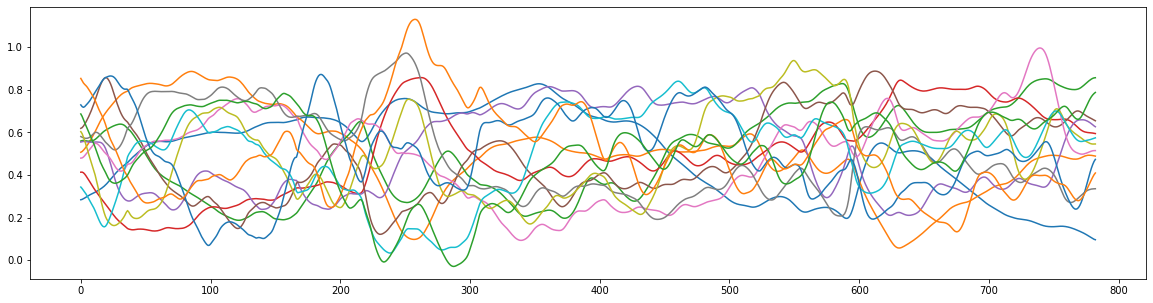

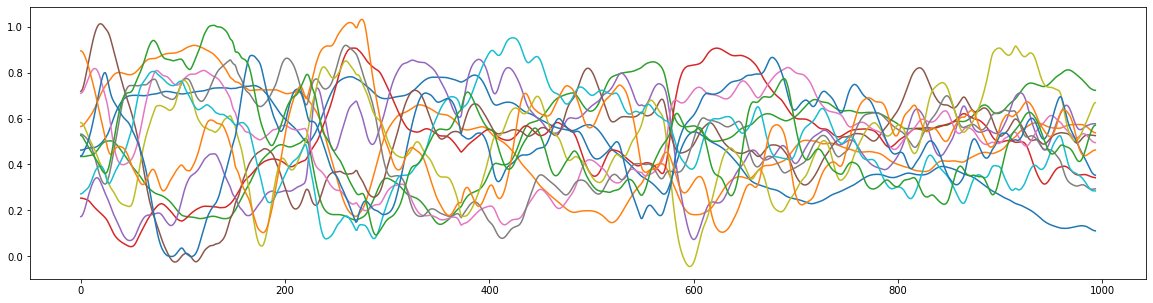

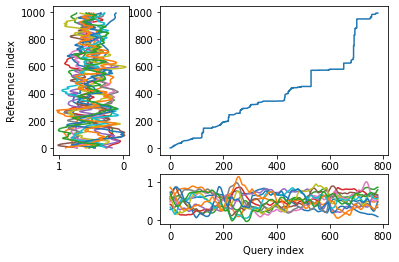

Stretch = 0.84

Distance  = 0.15
                         1        2         3
seg                 speech    pause    speech
start in voice 1   3.46488  3.67235   3.73719
start in voice 2   7.60588  7.81435   7.87818
stretch           0.834254  0.85639  0.811354


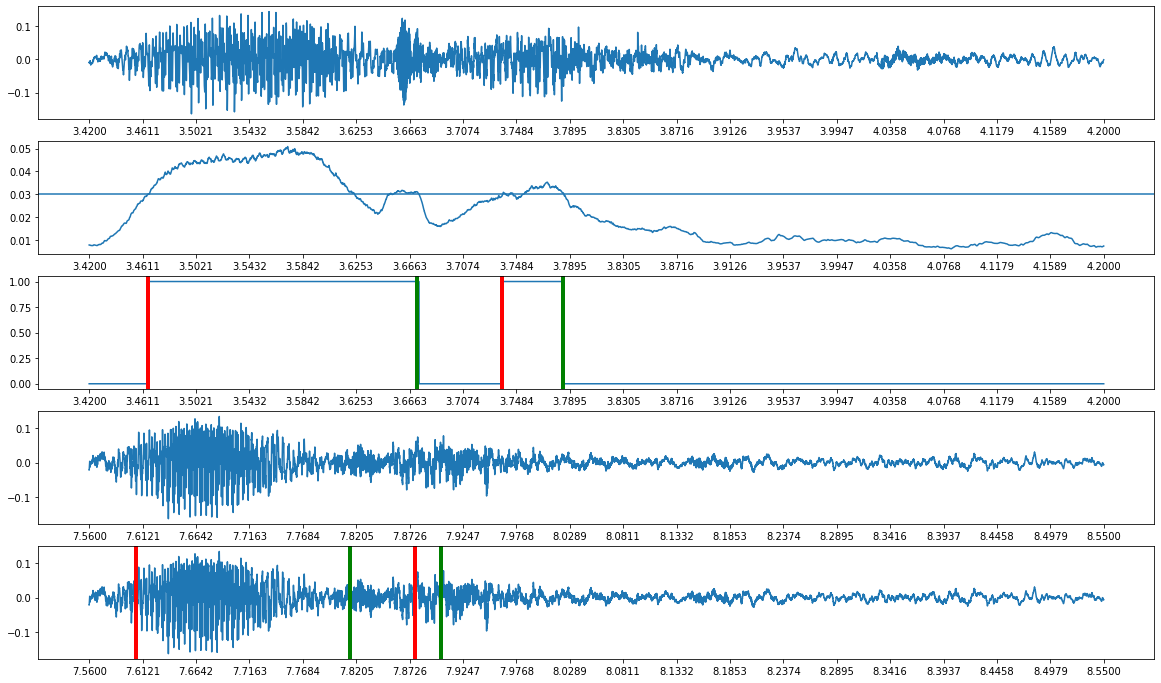

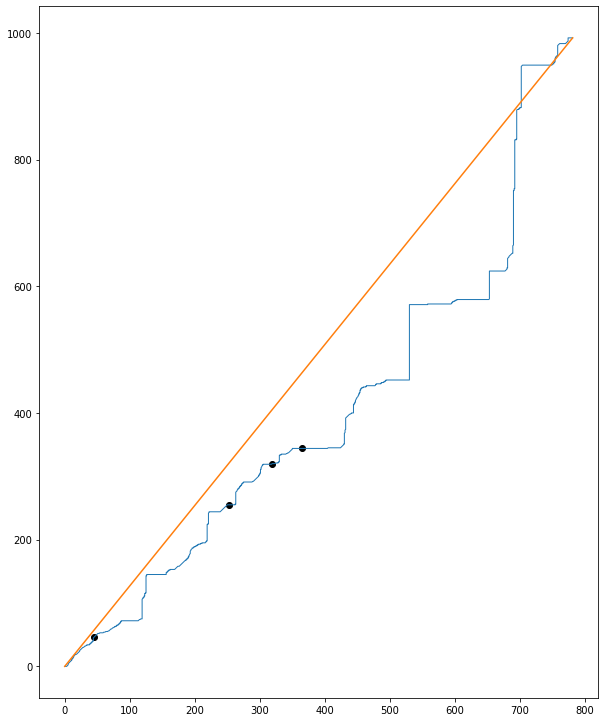

In [377]:
# should give dtw close to 0 and very small stretch

file1, seg1_1, seg1_2 = "report-normal1.wav", 3.42, 4.20 # "project"
file2, seg2_1, seg2_2 = "report-pause1.wav", 7.56, 8.55 # "project"

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1=0.03)

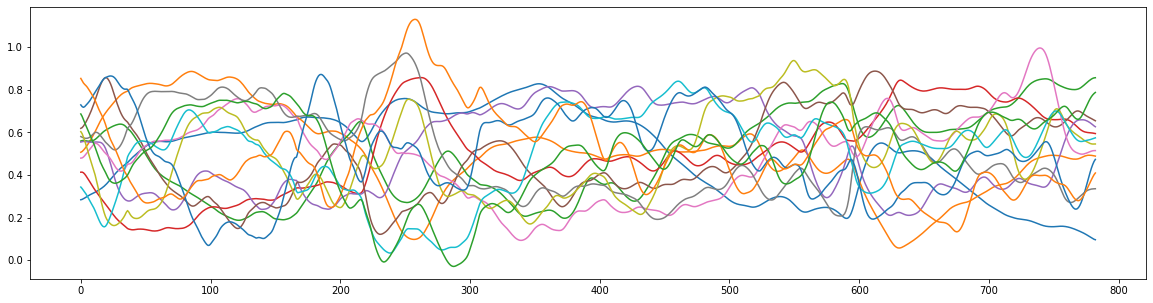

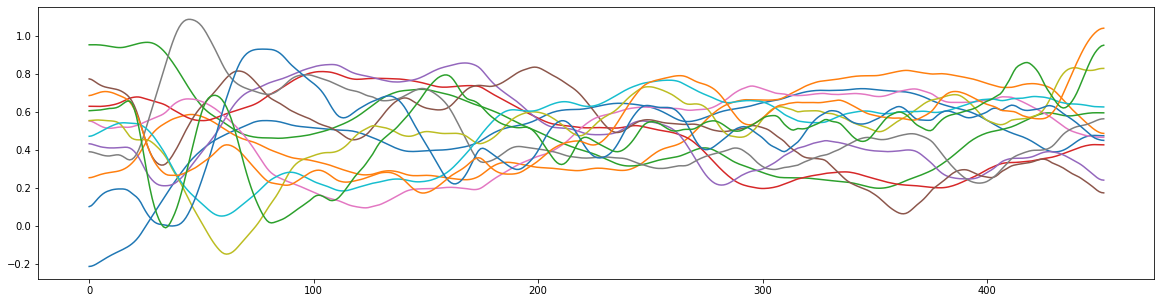

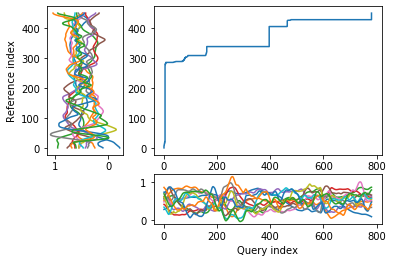

Stretch = 0.94

Distance  = 0.23
                         1        2        3
seg                 speech    pause   speech
start in voice 1   3.45391  3.67634  3.71026
start in voice 2   2.23527  2.28813  2.28813
stretch           0.952499        1        1


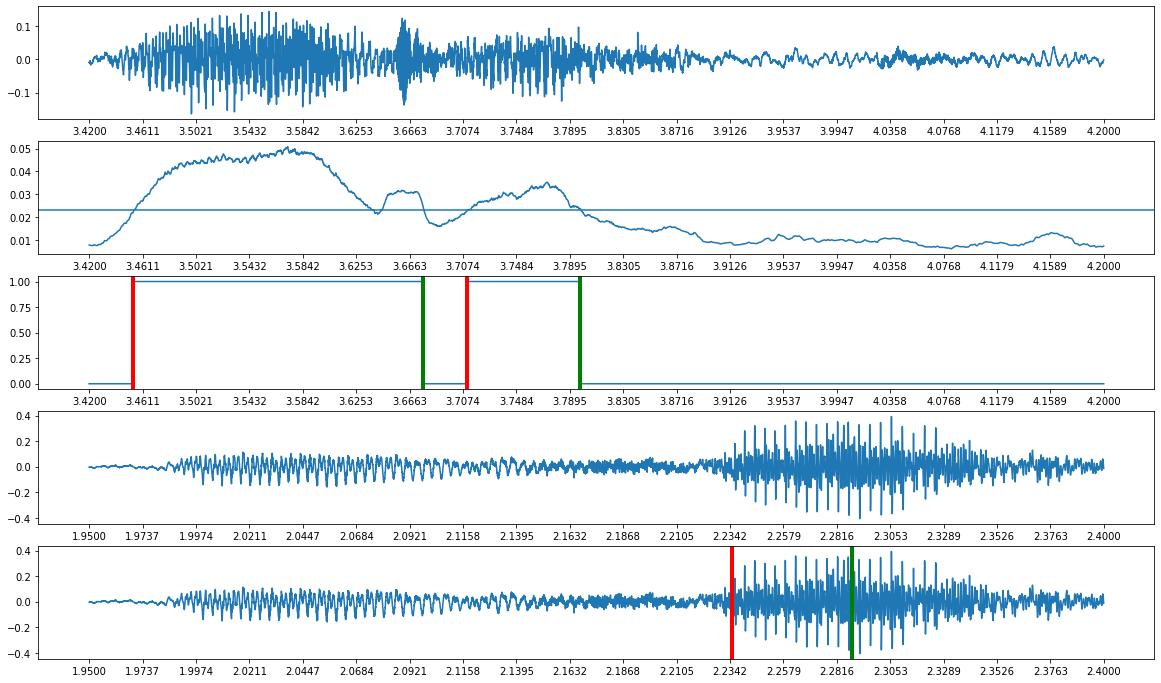

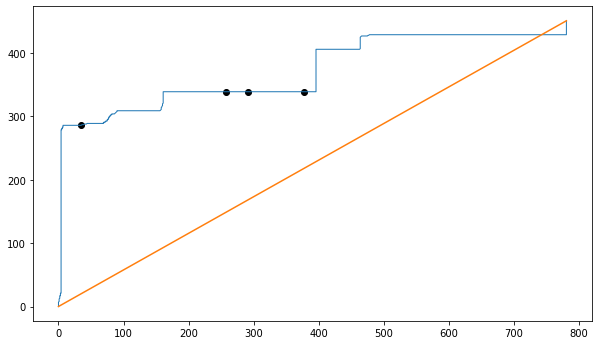

In [378]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 3.42, 4.20 # "project"
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.95, 2.40 # "we have"

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1=0.023, num_of_mfcc=13)

# We have really enjoyed the project - by word, normal1

### normal vs normal

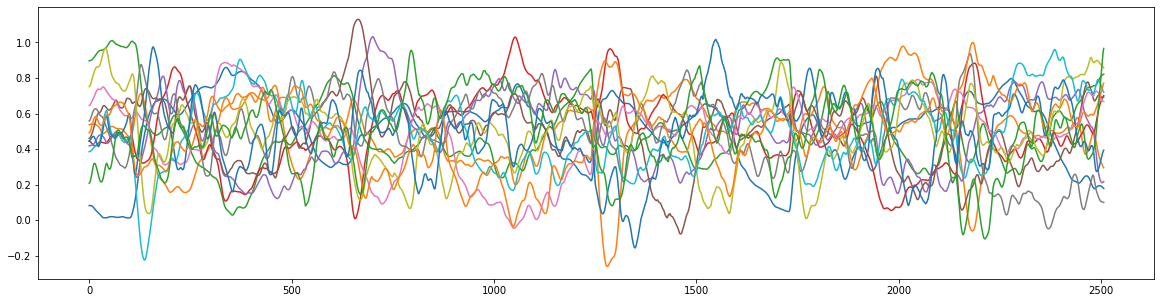

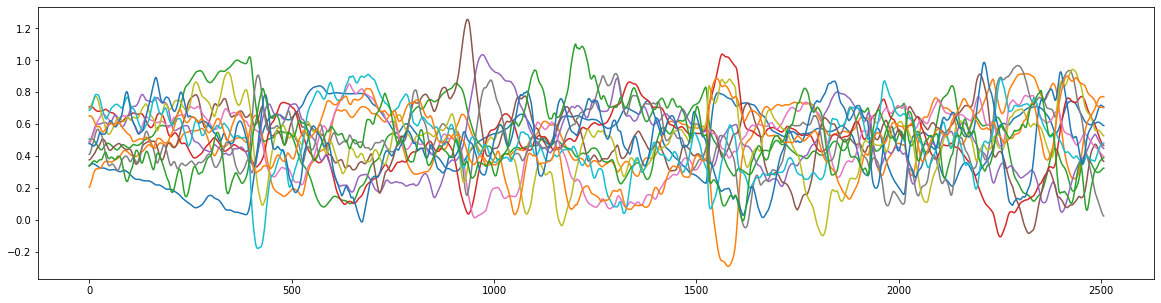

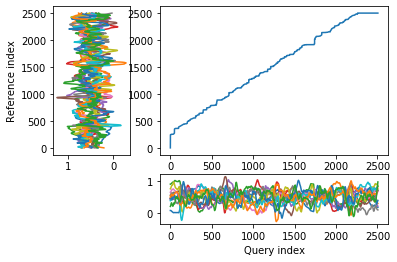

Stretch = 0.81

Distance  = 0.11
                        1         2         3         4        5         6   \
seg                 speech     pause    speech     pause   speech     pause   
start in voice 1    1.6267   1.73344   1.78033   1.96788  2.14146   2.74202   
start in voice 2   1.90902   2.00678   2.05367    2.2502  2.41081   3.02235   
stretch           0.821307  0.729426  0.859713  0.884652  0.83311  0.664931   

                        7         8         9         10        11  
seg                 speech     pause    speech     pause    speech  
start in voice 1   2.81085   3.09816   3.25678   3.31165   3.45032  
start in voice 2   3.10315   3.40144   3.56305     3.582   3.71668  
stretch           0.832232  0.893886  0.762703  0.845077  0.795637  


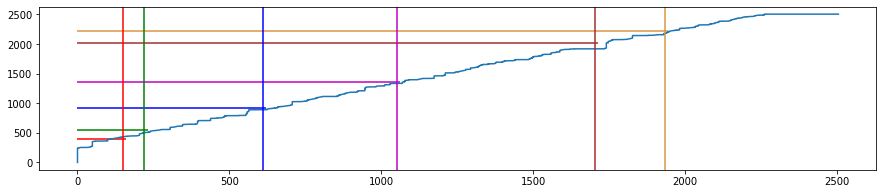

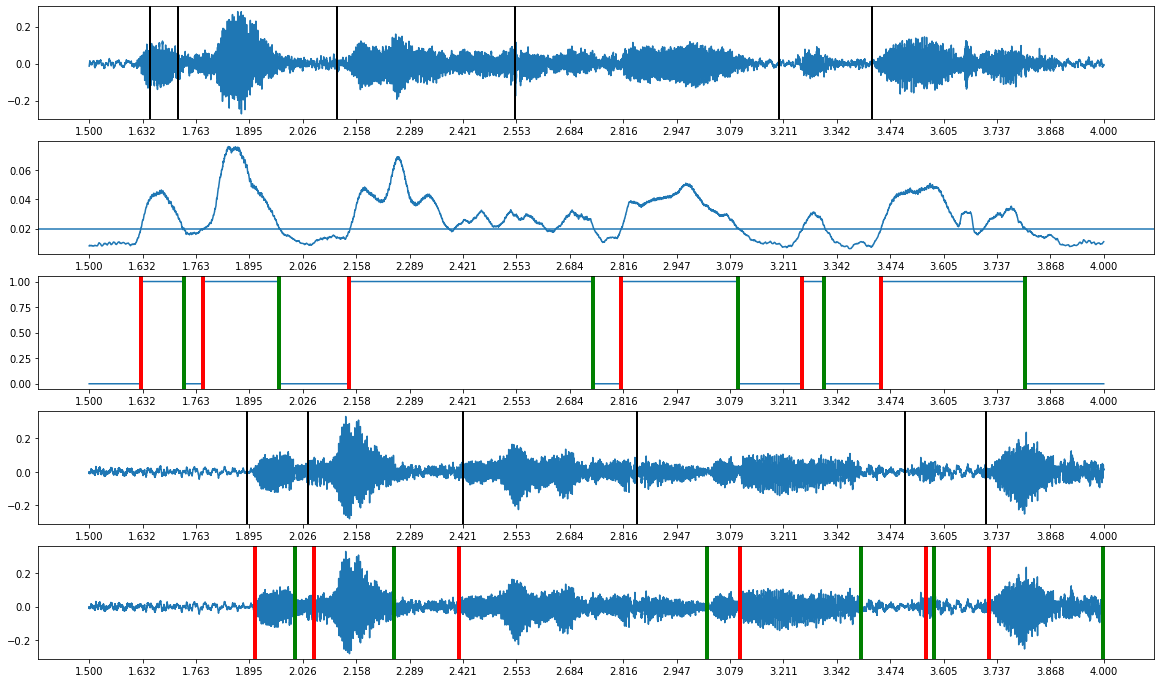

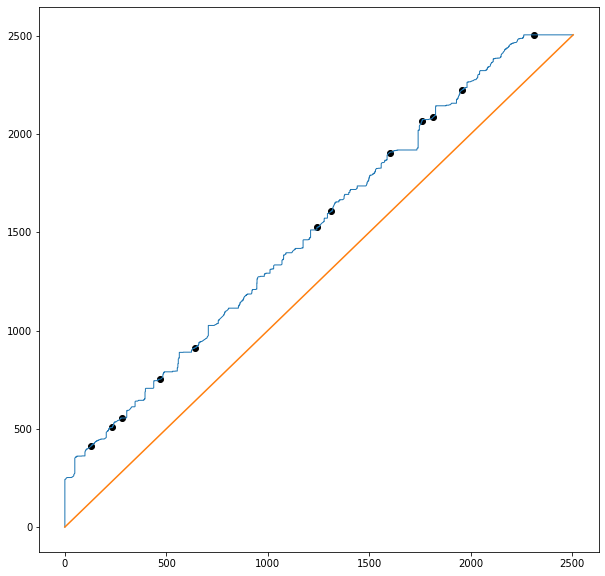

In [379]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal2.wav", 1.5, 4

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1=0.02, 
      timelst1=timelst1, timelst2 = timelst2)
# unit for input_min_pause and alpha = ms 

### noraml vs normal (inserted pause)

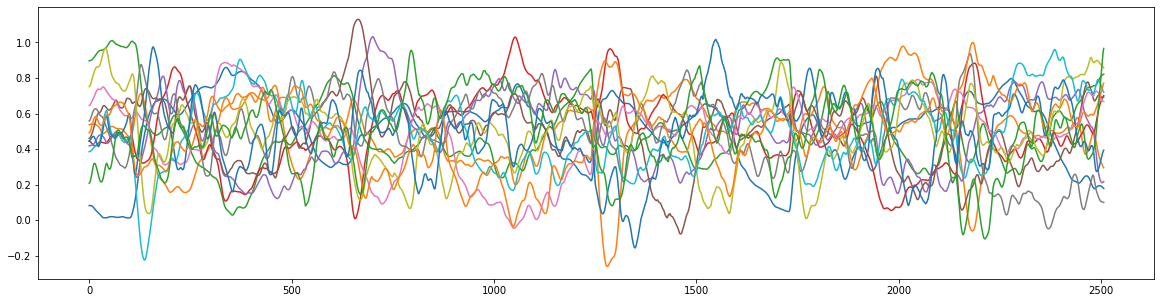

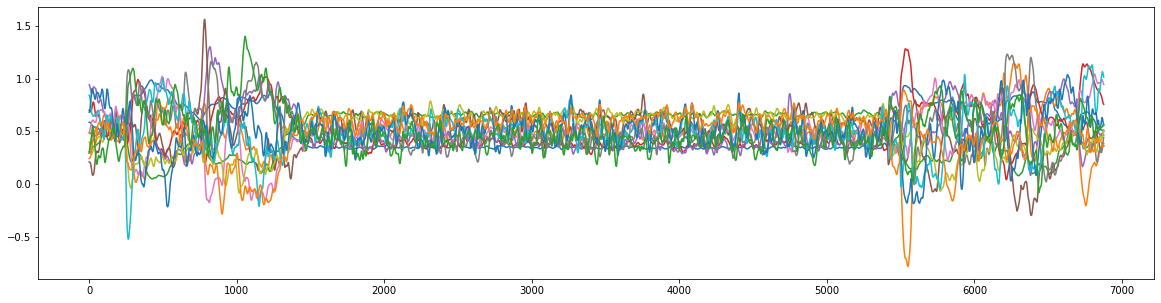

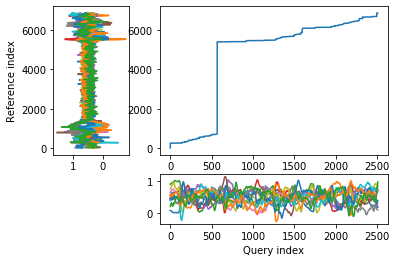

Stretch = 0.99

Distance  = 0.16
                        1        2         3        4         5         6   \
seg                 speech    pause    speech    pause    speech     pause   
start in voice 1    1.6257  1.73743   1.77135  1.97386   2.14046   2.74601   
start in voice 2    2.7194  2.85707   2.89199  3.07854   7.86405   7.95184   
stretch           0.923025  0.76963  0.918819  0.99559  0.962366  0.875478   

                        7         8         9         10        11  
seg                 speech     pause    speech     pause    speech  
start in voice 1   2.80786   3.10814   3.25279   3.31664   3.44733  
start in voice 2   8.03365   8.56038   8.59929   8.60228   8.64817  
stretch           0.925169  0.948371  0.971945  0.968366  0.889067  


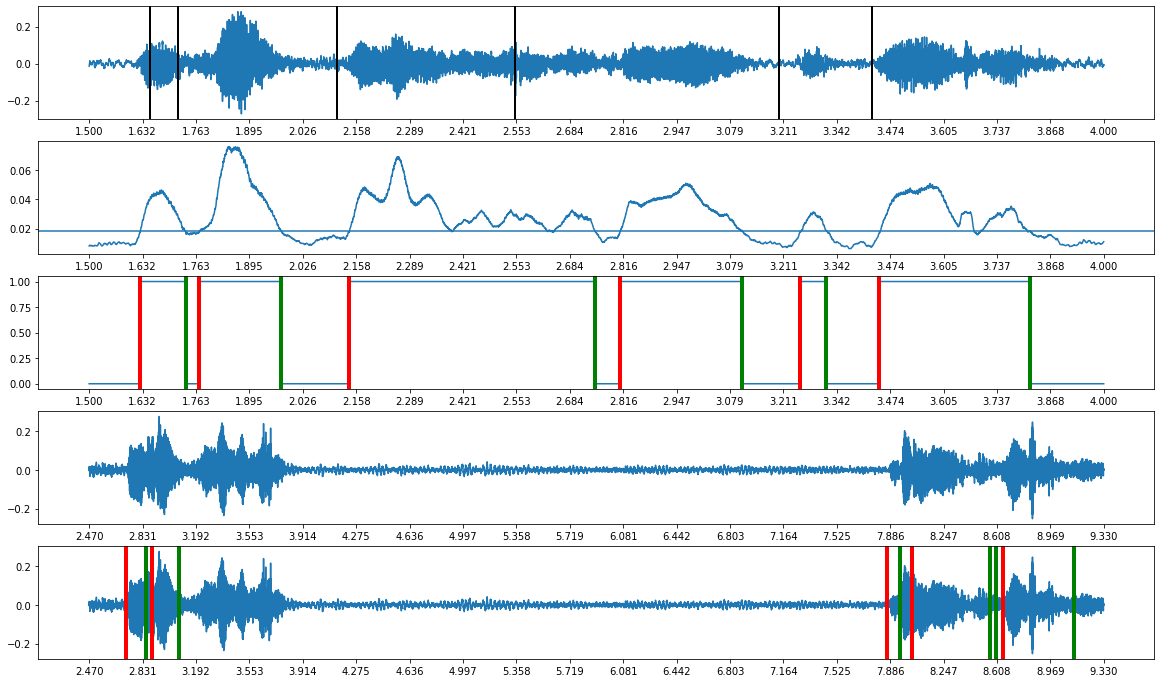

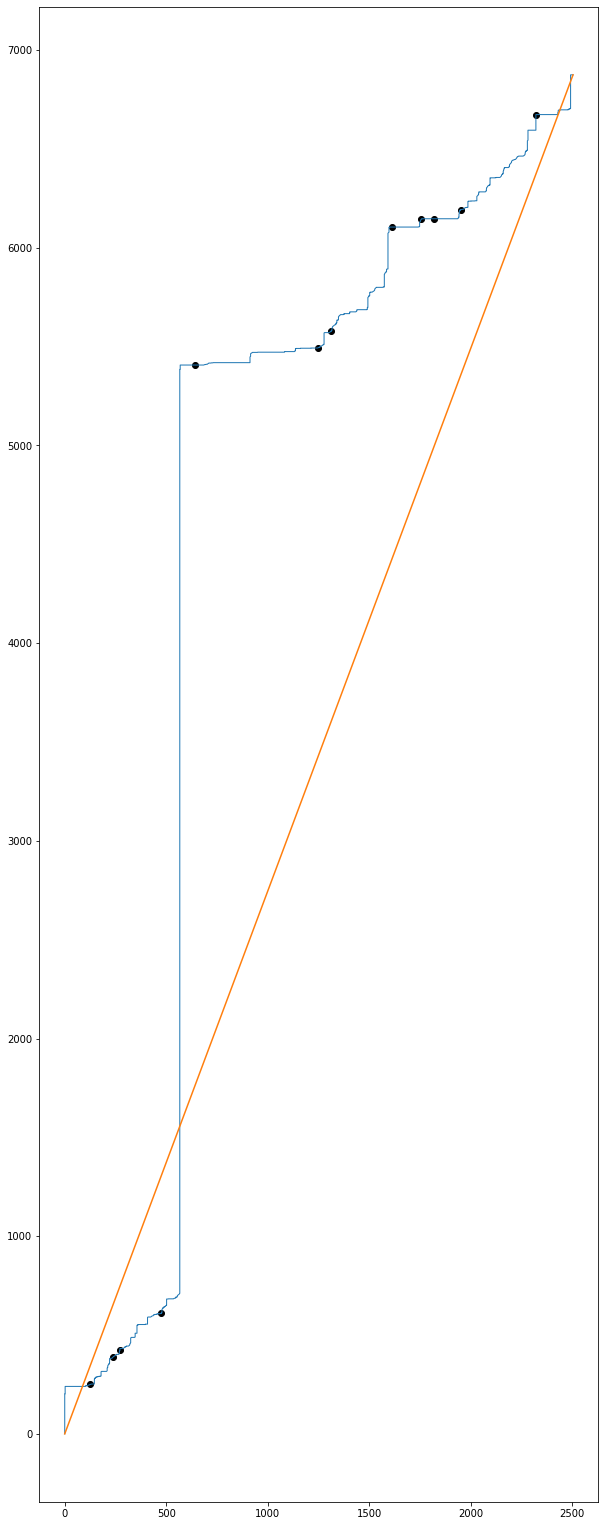

In [381]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal2-pause.wav", 2.47, 9.33

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = []

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.018,
      timelst1=timelst1, timelst2 = timelst2)

### normal vs pause

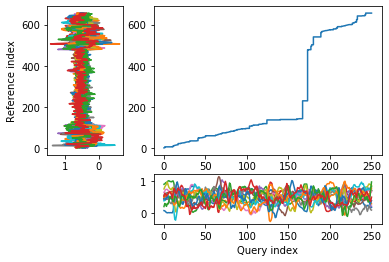

Stretch = 0.97

Distance  = 0.16
                        1         2         3         4         5        6   \
seg                 speech     pause    speech     pause    speech    pause   
start in voice 1   1.61952   1.72908   1.77888   1.95817   2.13745  2.73506   
start in voice 2    1.9796   2.11904   2.16884   2.37801   2.50749   3.0553   
stretch           0.730401  0.557654  0.921646  0.898637  0.778957        1   

                       7         8        9        10       11  
seg                speech     pause   speech    pause   speech  
start in voice 1  2.80478   3.08367  3.24303  3.30279  3.44223  
start in voice 2  3.23458    3.2545  6.64096  7.25849  7.56725  
stretch                 1  0.997403  0.98614  0.90944  0.81699  


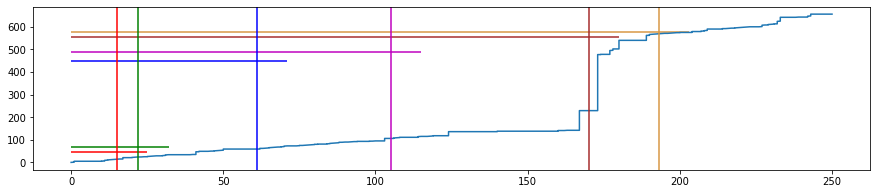

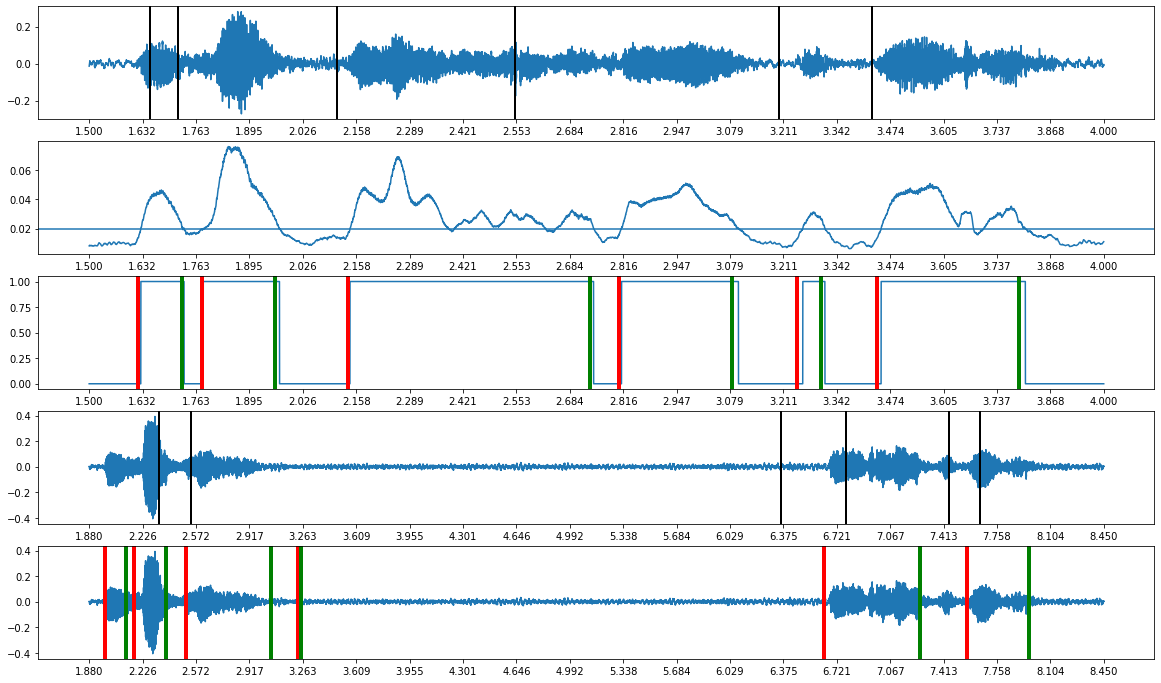

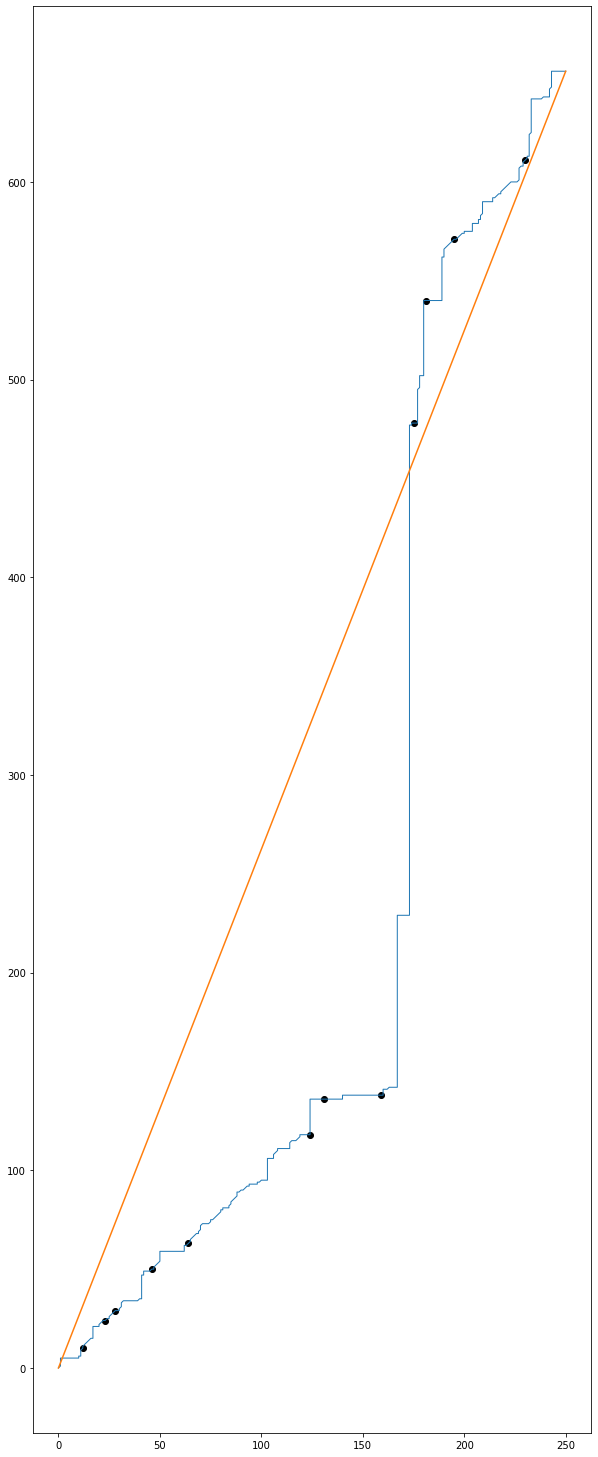

In [335]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.88, 8.45

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2, num_of_mfcc = 14)

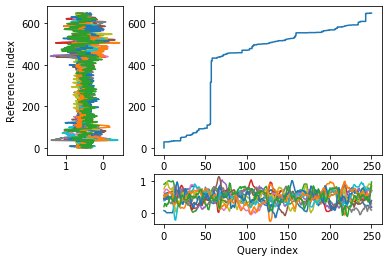

Stretch = 0.96

Distance  = 0.14
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   1.61952   1.72908   1.77888   1.95817   2.13745   2.73506   
start in voice 2   2.32869   2.50797   2.60757   2.91633   6.31275         7   
stretch           0.966338  0.753755  0.919152  0.989621  0.867099  0.653626   

                        7         8        9         10       11  
seg                 speech     pause   speech     pause   speech  
start in voice 1   2.80478   3.08367  3.24303   3.30279  3.44223  
start in voice 2   7.07968   7.38845  7.53785   7.53785  7.63745  
stretch           0.757079  0.935979        1  0.911389  0.75531  


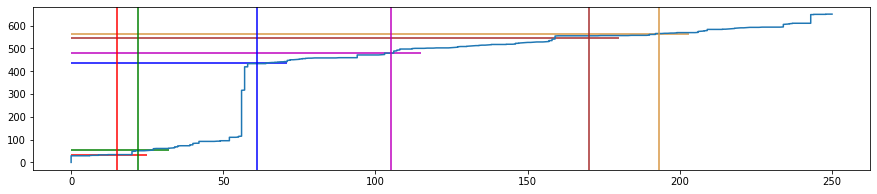

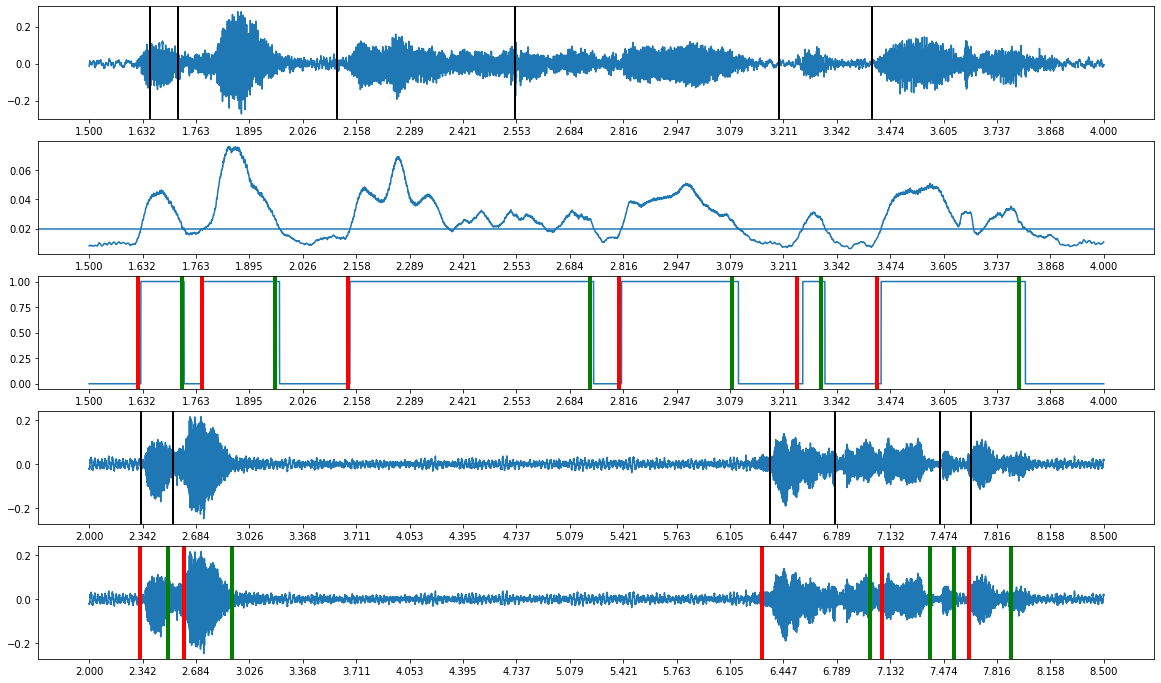

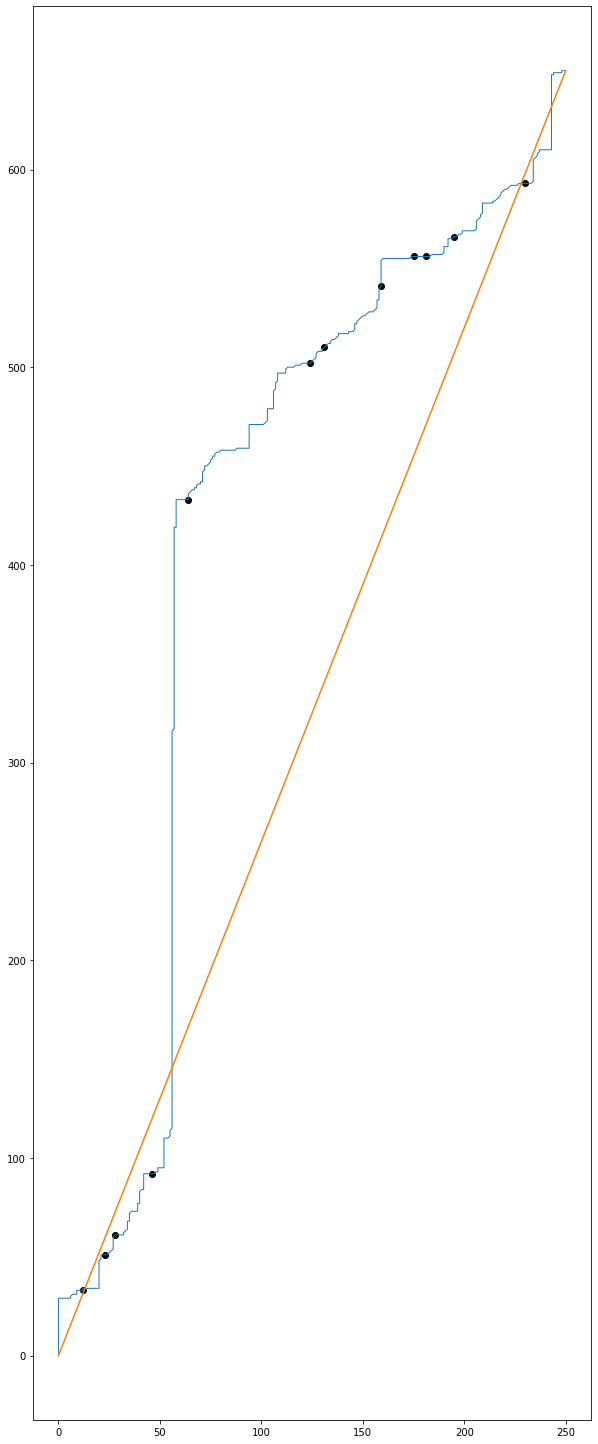

In [332]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2)

### normal vs long word

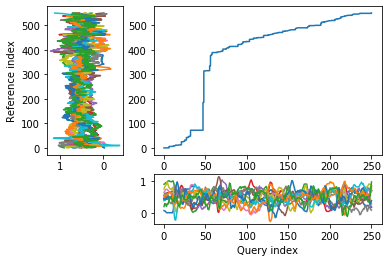

Stretch = 0.97

Distance  = 0.15
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   1.61952   1.72908   1.77888   1.95817   2.13745   2.73506   
start in voice 2   1.56972     1.749   1.91833   2.21713    5.3745   6.07171   
stretch           0.848654  0.952447  0.957635  0.985339  0.870161  0.780082   

                        7         8        9         10        11  
seg                 speech     pause   speech     pause    speech  
start in voice 1   2.80478   3.08367  3.24303   3.30279   3.44223  
start in voice 2   6.12151   6.34064  6.44024   6.47012   6.62948  
stretch           0.769645  0.869067        1  0.930232  0.700172  


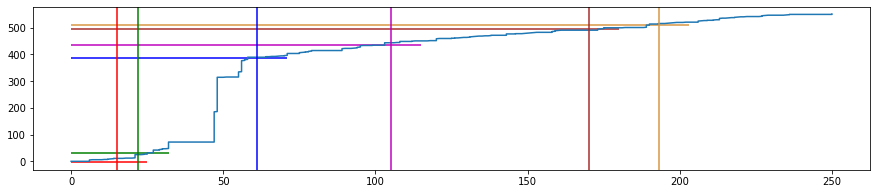

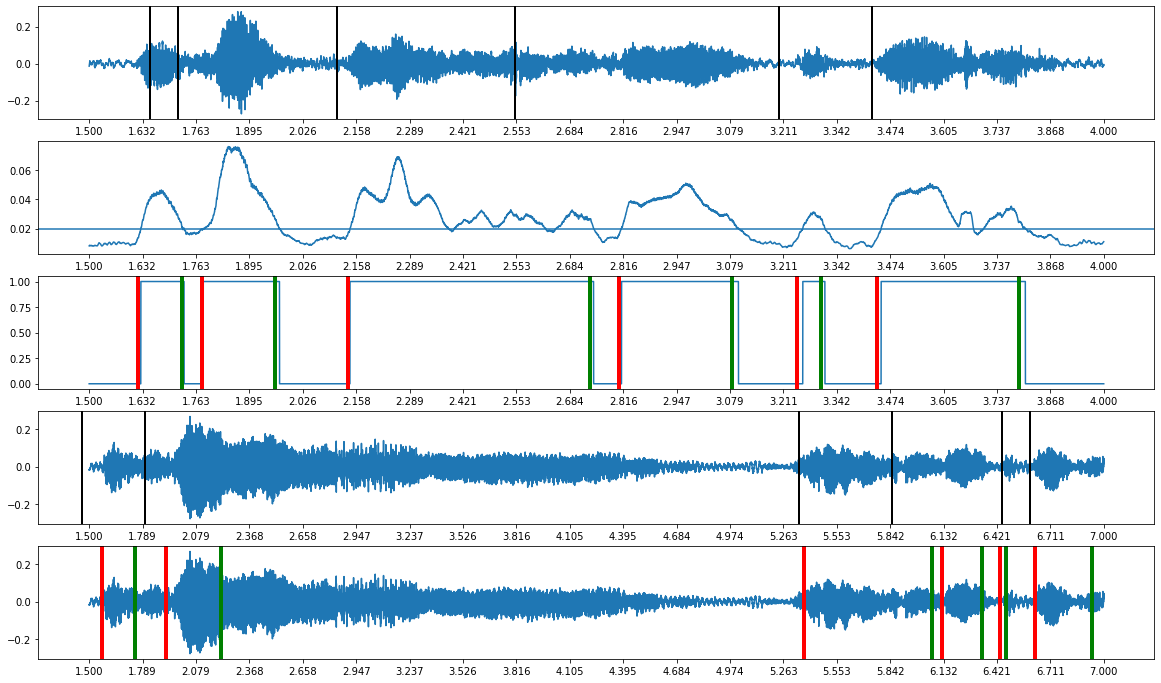

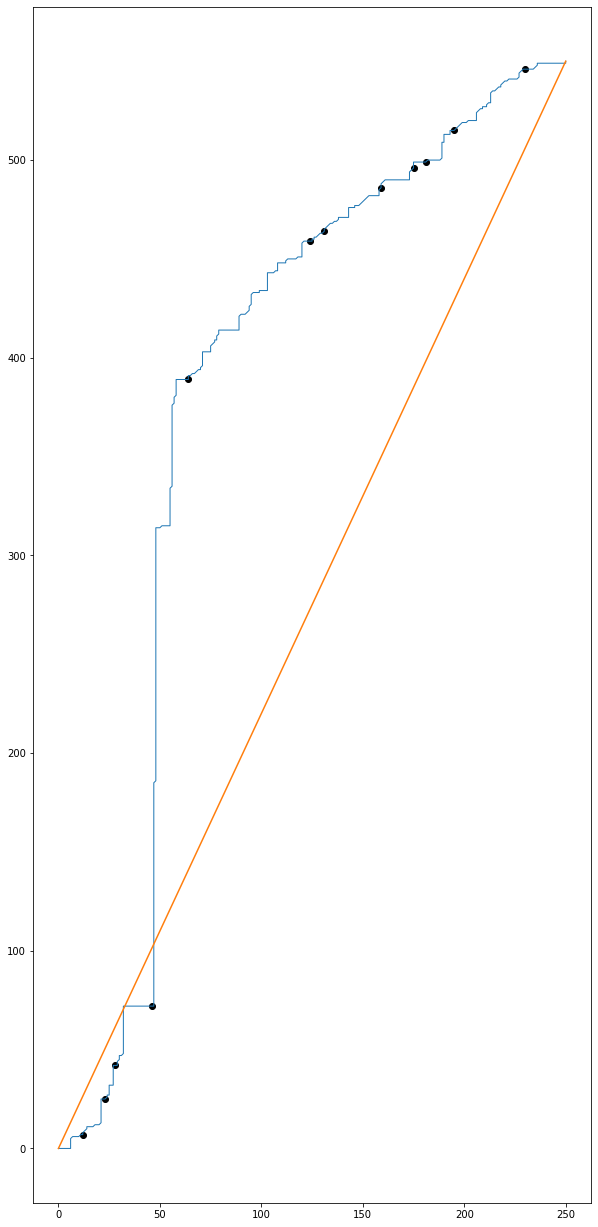

In [322]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.46, 1.80, 5.35, 5.85, 6.45, 6.6]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2)

### normal vs combo

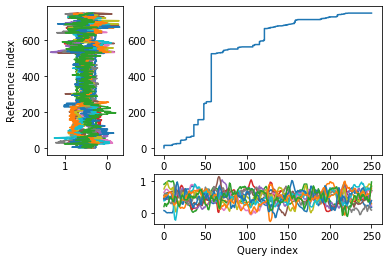

Stretch = 0.97

Distance  = 0.16
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   1.61952   1.72908   1.77888   1.95817   2.13745   2.73506   
start in voice 2   1.70916   1.92829   2.08765   3.06375     6.749   8.11355   
stretch           0.911788  0.853762  0.984376  0.990729  0.938635  0.835755   

                        7         8        9         10        11  
seg                 speech     pause   speech     pause    speech  
start in voice 1   2.80478   3.08367  3.24303   3.30279   3.44223  
start in voice 2   8.18327   8.57171  8.61155   8.61155   8.68127  
stretch           0.815923  0.951708        1  0.954196  0.844378  


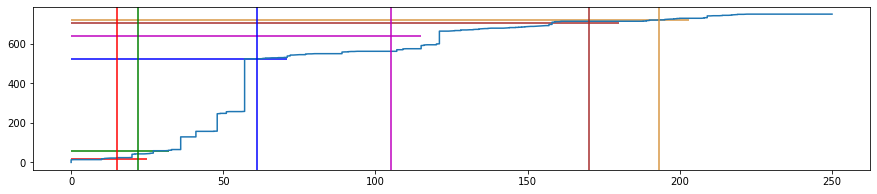

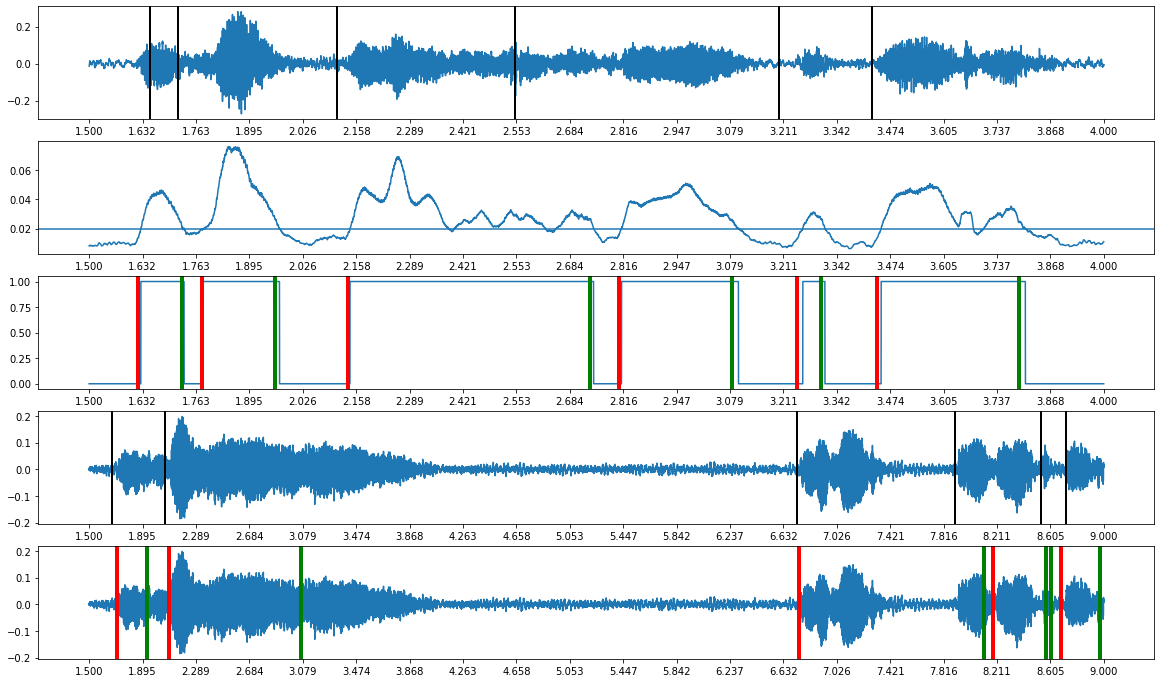

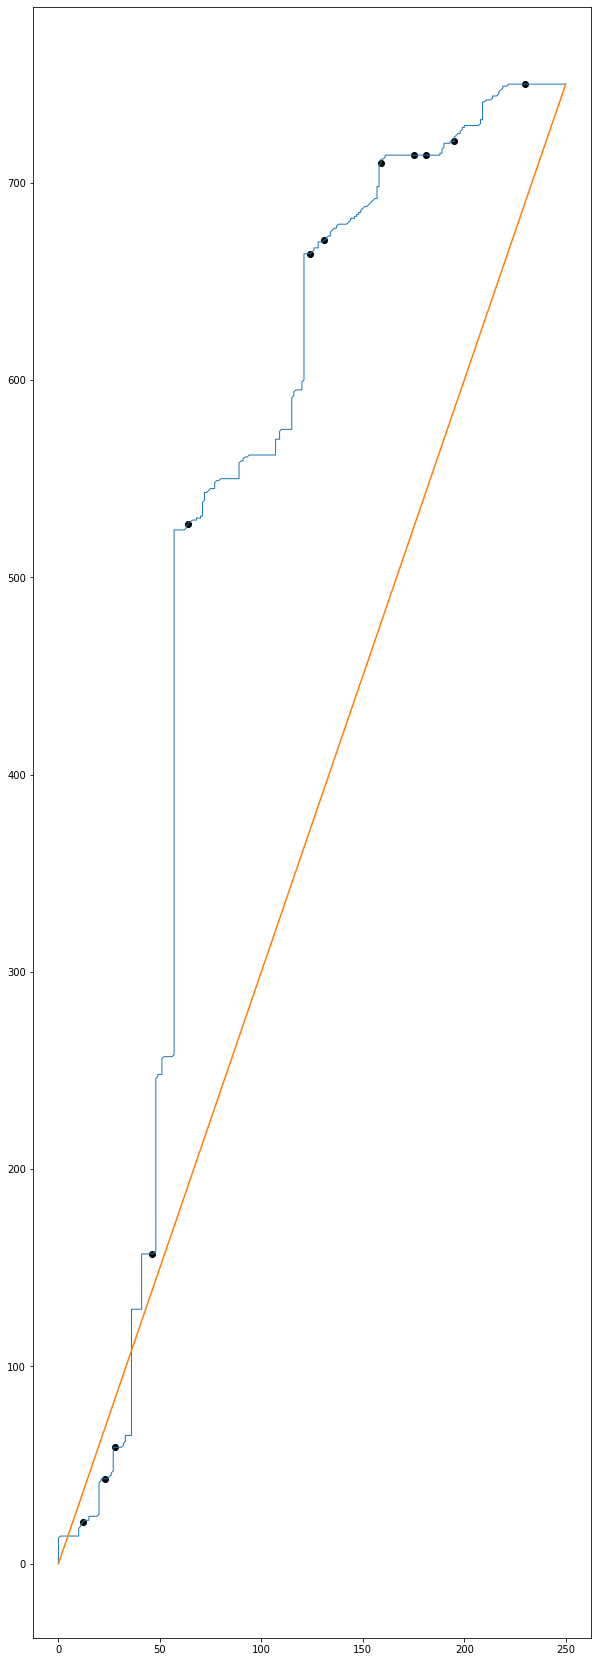

In [323]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2)

### normal vs something random

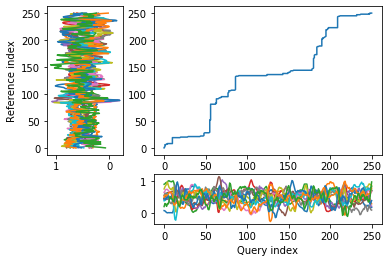

Step pattern recursion:
 g[i,j] = min(
     g[i-1,j-1] + 2 * d[i  ,j  ] ,
     g[i  ,j-1] +     d[i  ,j  ] ,
     g[i-1,j  ] +     d[i  ,j  ] ,
 ) 

Normalization hint: N+M

Stretch = 0.88

Distance  = 0.19
distance 350.01515418306525
(251, 251)
350.01515418306525
465
                        1        2         3         4        5        6   \
seg                 speech    pause    speech     pause   speech    pause   
start in voice 1   1.61952  1.72908   1.77888   1.95817  2.13745  2.73506   
start in voice 2   1.68924   1.6992    1.6992   1.71912  2.40637  2.84462   
stretch           0.864204        1  0.841353  0.949638  0.88374        1   

                        7        8         9         10       11  
seg                 speech    pause    speech     pause   speech  
start in voice 1   2.80478  3.08367   3.24303   3.30279  3.44223  
start in voice 2   2.85458  2.93426   2.93426   3.16335  3.56175  
stretch           0.826779        1  0.890492  0.855901  0.91879  


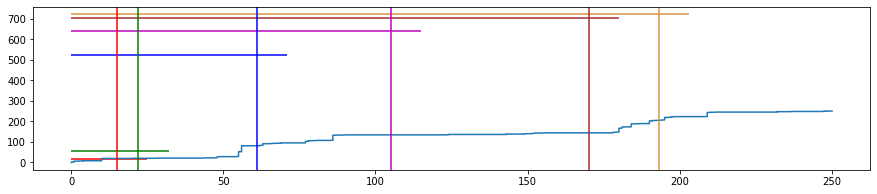

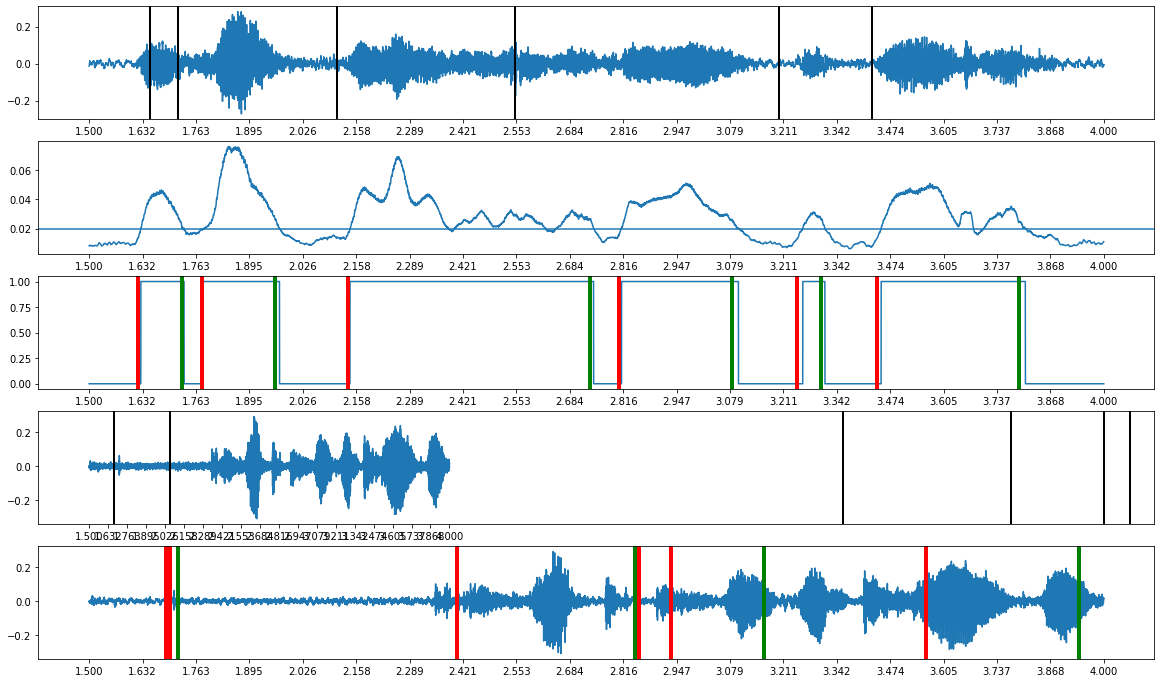

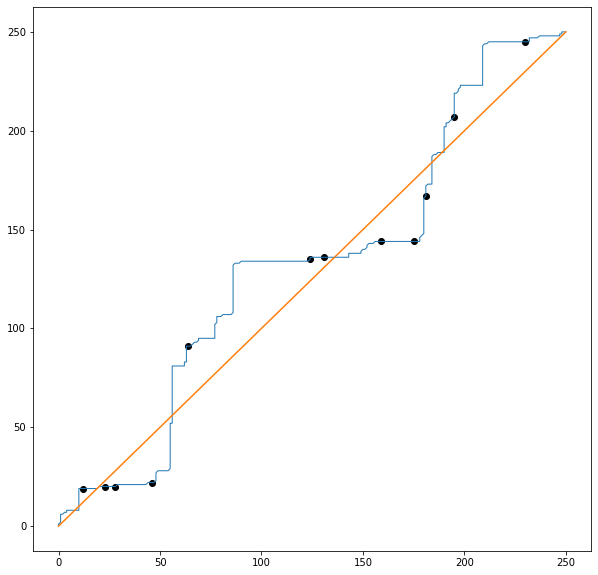

In [313]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "torgo-healthy.wav", 1.5, 4

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2)

# We have really enjoyed the project - by word, normal2

### normal vs pause

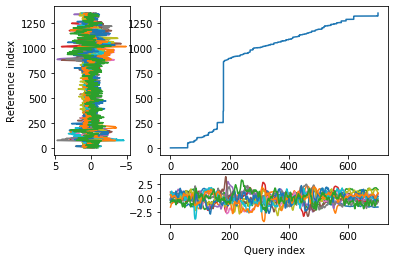

Overall normalized stretch =  0.9663331304006694
                       1         2         3         4         5         6   \
seg                speech     pause    speech     pause    speech     pause   
start in voice 1  1.90883   2.25783   2.40741    2.9708   3.03561   3.39459   
start in voice 2    2.349   2.92735   6.31766    7.0057    7.0406   7.34972   
stretch           0.88194  0.995686  0.825393  0.879134  0.859488  0.896376   

                        7         8         9         10        11  
seg                 speech     pause    speech     pause    speech  
start in voice 1   3.54915   3.59402   3.72365   4.11752   4.19729  
start in voice 2   7.46439   7.54416   7.65883   8.09758   8.12251  
stretch           0.803069  0.908906  0.875232  0.891973  0.977102  

DTW distance =  2.4434178655310426


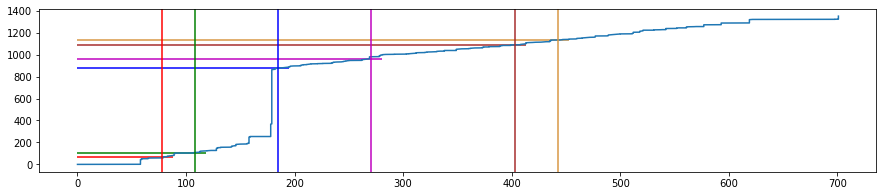

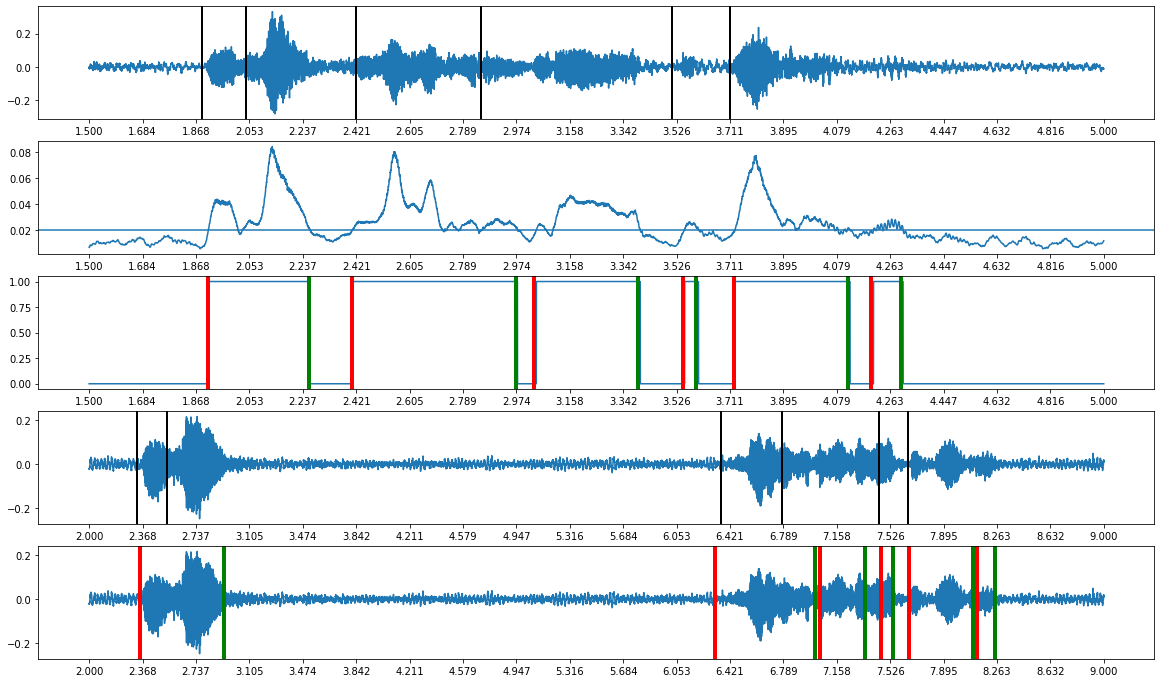

In [103]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 9

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2)

### normal vs long word

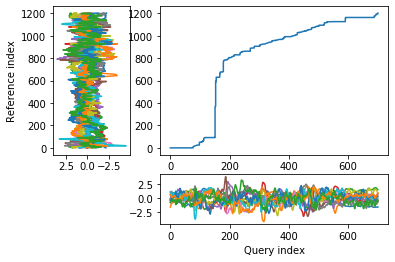

Overall normalized stretch =  0.9512025776550707
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   1.90883   2.25783   2.40741    2.9708   3.03561   3.39459   
start in voice 2   1.58476   3.33476   5.38889   6.01709   6.10185   6.32621   
stretch           0.974219  0.985359  0.895908  0.882709  0.749242  0.923452   

                        7         8         9         10        11  
seg                 speech     pause    speech     pause    speech  
start in voice 1   3.54915   3.59402   3.72365   4.11752   4.19729  
start in voice 2    6.4708   6.49573   6.66524    7.0641   7.10897  
stretch           0.803276  0.882709  0.877691  0.856343  0.947825  

DTW distance =  2.645631188944761


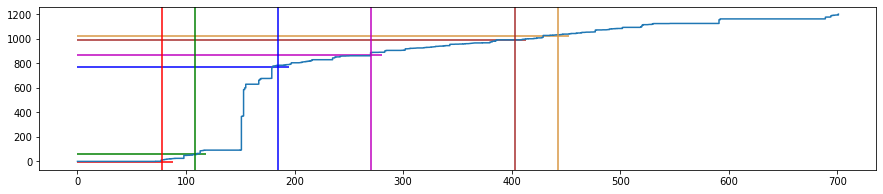

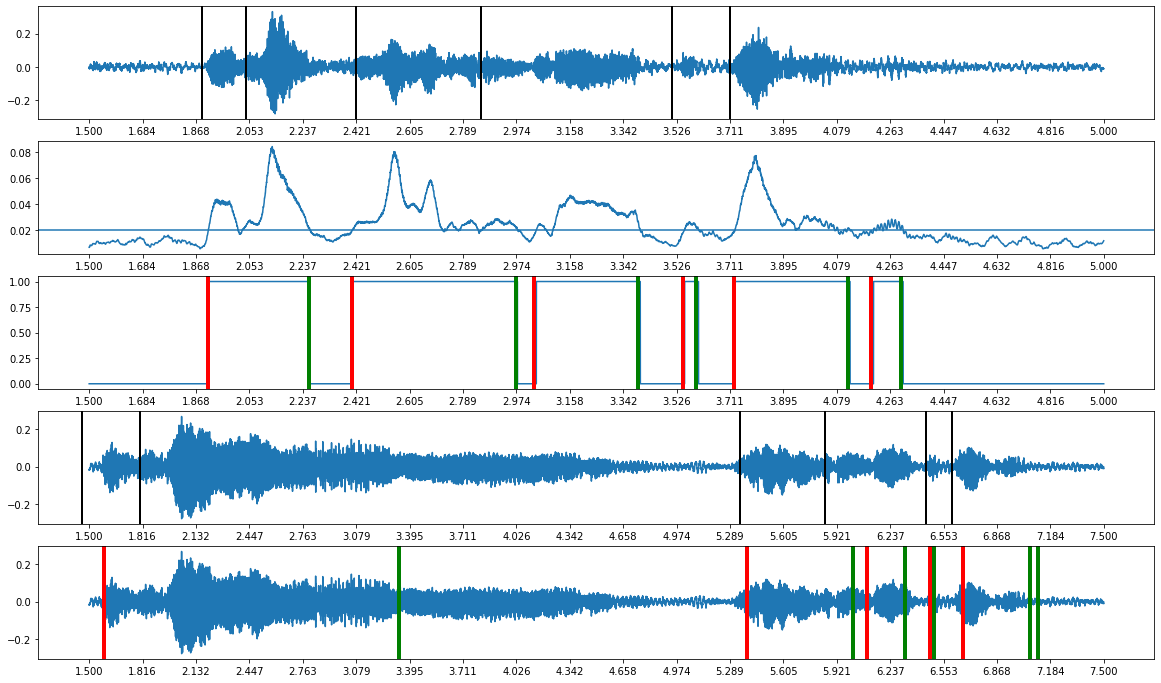

In [104]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7.5

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [1.46, 1.80, 5.35, 5.85, 6.45, 6.6]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2)

### normal vs combo

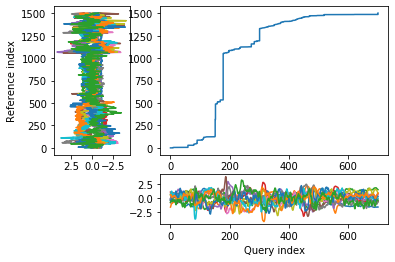

Overall normalized stretch =  0.9693590233595608
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   1.90883   2.25783   2.40741    2.9708   3.03561   3.39459   
start in voice 2   1.71439   3.08048   6.76994   7.44801   8.15598   8.49501   
stretch           0.956055  0.992315  0.917122  0.987102  0.748816  0.819154   

                        7         8         9         10       11  
seg                 speech     pause    speech     pause   speech  
start in voice 1   3.54915   3.59402   3.72365   4.11752  4.19729  
start in voice 2   8.55484   8.59473    8.7443   8.90883  8.91382  
stretch           0.858388  0.749851  0.916652  0.936478        1  

DTW distance =  2.949194602915999


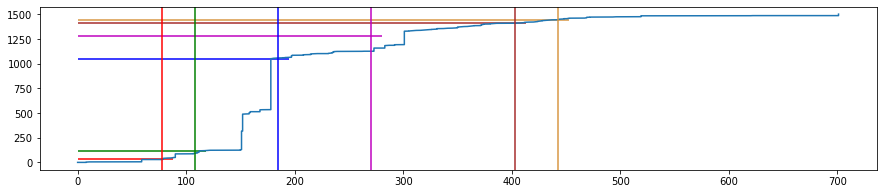

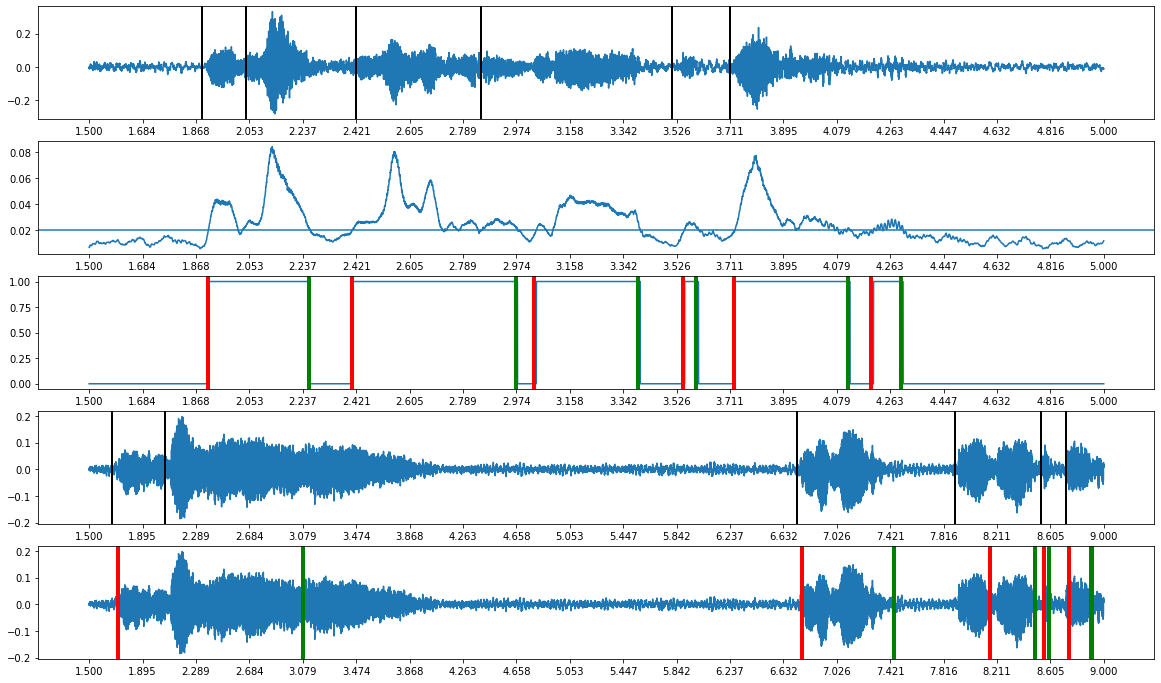

In [24]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2)

# bamboo walls are getting to be very popular

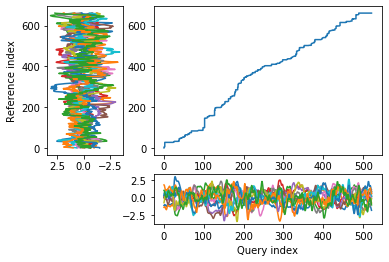

Overall normalized stretch =  0.8710804521234169
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   3.52452   3.69387   3.74368   3.87318   3.90805   4.14215   
start in voice 2   1.84444   2.01877   2.07356   2.12835   2.19808   2.76092   
stretch           0.865297  0.869385  0.892271  0.936663  0.919178  0.831307   

                        7        8         9         10       11        12  \
seg                 speech    pause    speech     pause   speech     pause   
start in voice 1    4.2567  4.33142   4.43103   4.76973  4.88429   4.92414   
start in voice 2   2.97011  3.25402   3.43831   3.74215  3.82184   3.85172   
stretch           0.945944  0.75477  0.845281  0.695575        1  0.772887   

                        13        14        15        16       17        18  \
seg                 speech     pause    speech     pause   speech     pause   
s

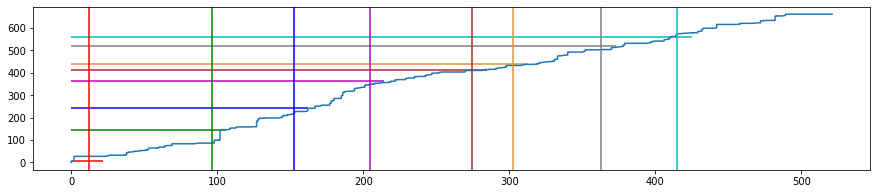

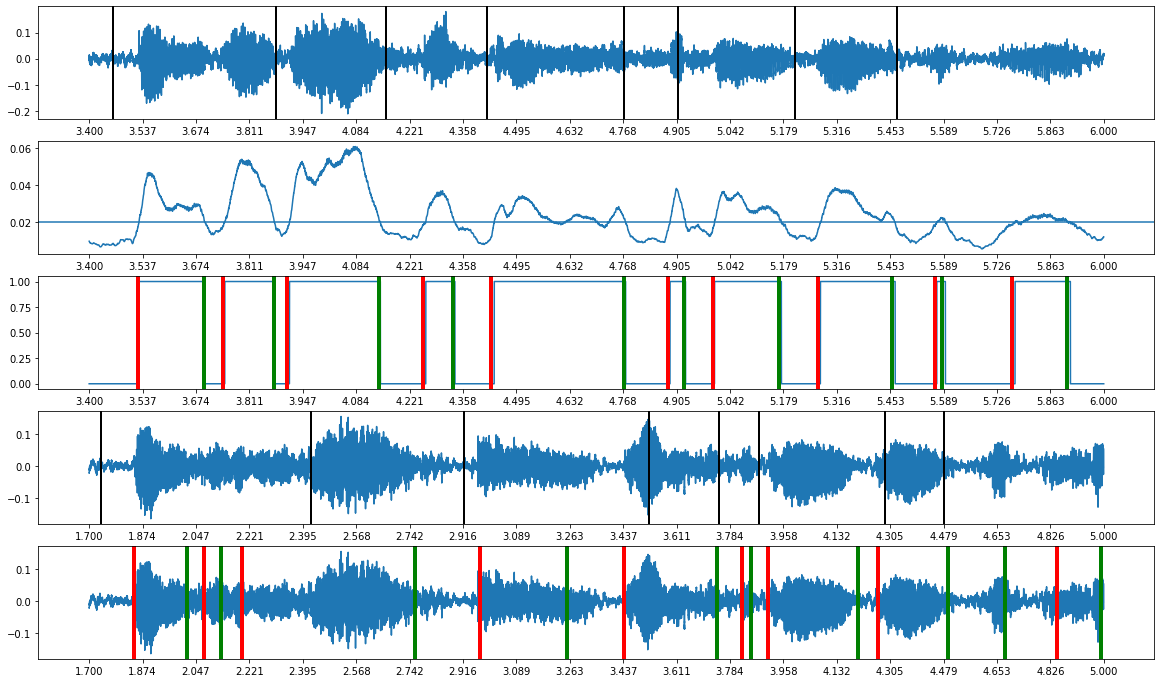

In [108]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "02.wav", 1.7, 5

timelst1 = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
timelst2 = [1.74, 2.42, 2.92, 3.52, 3.75, 3.88, 4.29, 4.48] 

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.02)
# unit = ms 

# bamboo walls are getting to be very popular

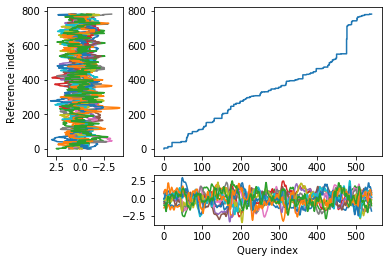

Overall normalized stretch =  0.9181980743604455
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   3.51919   4.15185   4.24151   4.37601   4.43081   4.77454   
start in voice 2    2.8893   3.84077   4.01513   4.16458   4.20941   4.44852   
stretch           0.904829  0.954709  0.889476  0.933903  0.895497  0.931949   

                        7         8         9         10        11        12  \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   4.87417   5.18303   5.26273   5.46697   5.55166   5.60148   
start in voice 2   4.53321   4.85701   4.92675   5.19576   5.43487   5.43985   
stretch           0.872528  0.873248  0.869413  0.905764  0.877736  0.976226   

                        13  
seg                 speech  
start in voice 1   5.73598  
start in voice 2    6.2917  
stretch           0.888284  

DTW

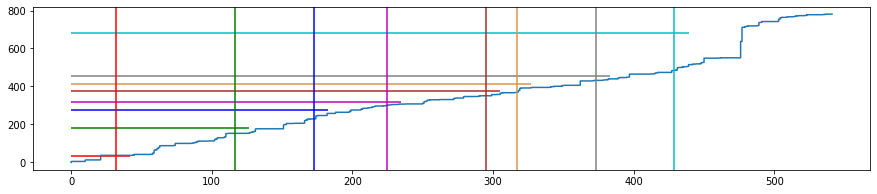

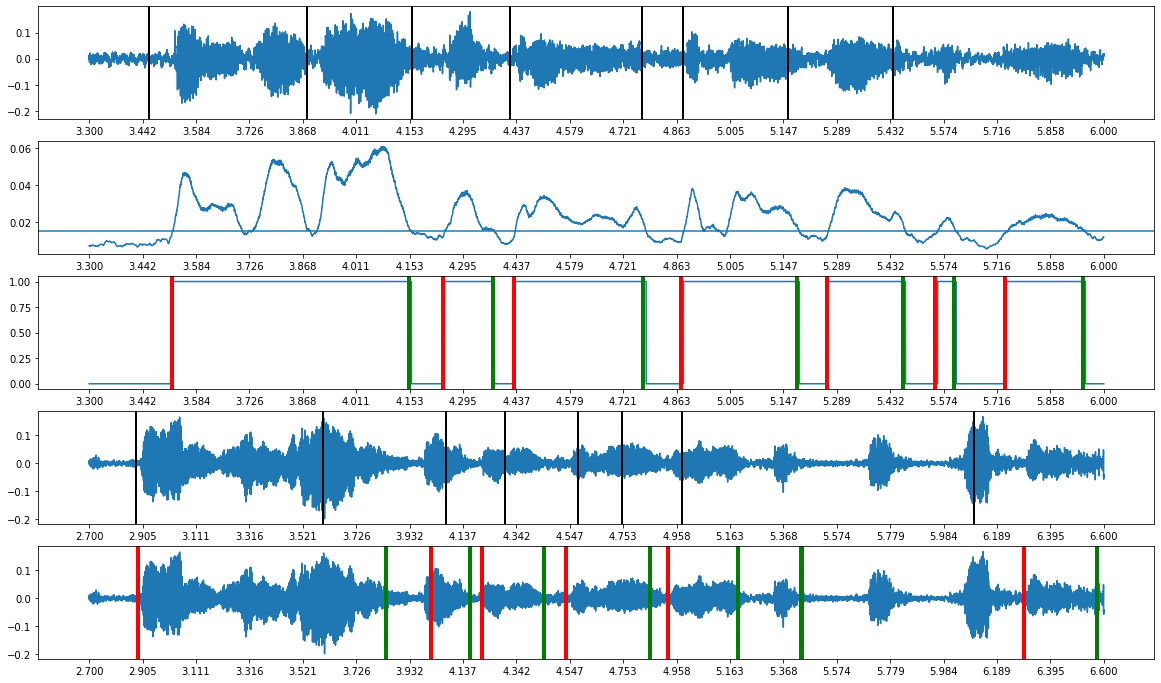

In [16]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 6.6

timelst1 = [3.46, 3.88, 4.16, 4.42, 4.77, 4.88, 5.16, 5.44]
timelst2 = [2.88, 3.6, 4.07, 4.3, 4.58, 4.75, 4.98, 6.10]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.015)

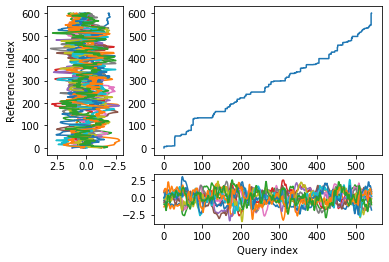

Overall normalized stretch =  0.9192353298631945
                        1         2         3        4         5        6   \
seg                 speech     pause    speech    pause    speech    pause   
start in voice 1   3.51919   4.15185   4.24151  4.37601   4.43081  4.77454   
start in voice 2   2.27399   2.91661   3.02122  3.19059   3.23044   3.4845   
stretch           0.930339  0.847001  0.883863  0.91924  0.907229        1   

                        7        8         9         10        11        12  \
seg                 speech    pause    speech     pause    speech     pause   
start in voice 1   4.87417  5.18303   5.26273   5.46697   5.55166   5.60148   
start in voice 2   3.48948  3.84815   3.85314   4.08229   4.15701   4.28155   
stretch           0.895737    0.914  0.920212  0.864005  0.960328  0.849605   

                        13  
seg                 speech  
start in voice 1   5.73598  
start in voice 2   4.38616  
stretch           0.807204  

DTW distance =  2.

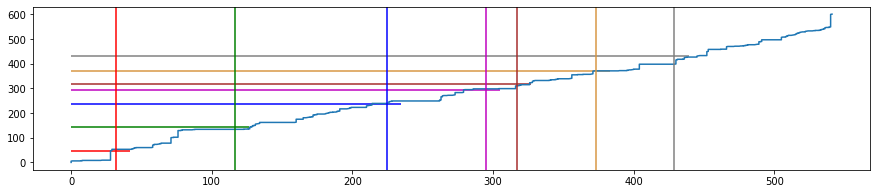

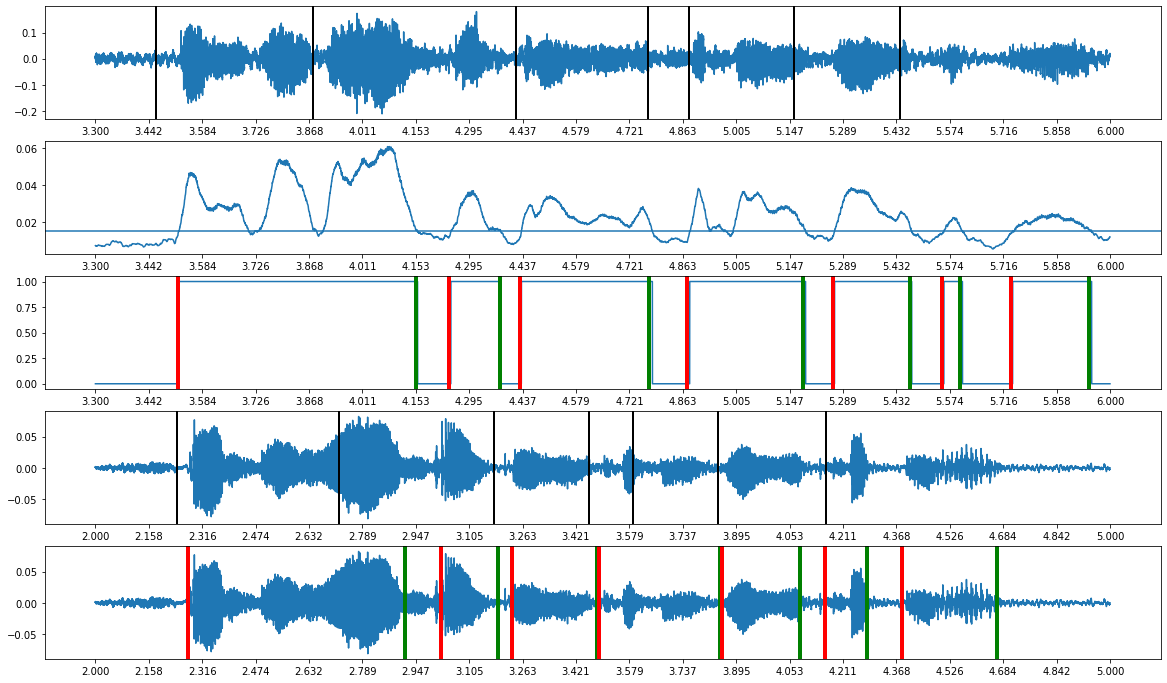

In [17]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5

timelst1 = [3.46, 3.88, 4.42, 4.77, 4.88, 5.16, 5.44] ;
timelst2 = [2.24, 2.72, 3.18, 3.46, 3.59, 3.84, 4.16]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.015)

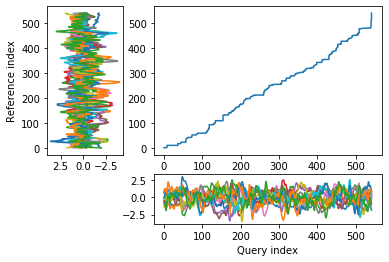

Overall normalized stretch =  0.8459936634456736
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   3.51919   4.15185   4.24151   4.37601   4.43081   4.77454   
start in voice 2   2.08967   2.69742   2.81199   2.98635   3.02122    3.2703   
stretch           0.886562  0.767433  0.743533  0.913842  0.833448  0.956371   

                        7         8         9         10        11       12  \
seg                 speech     pause    speech     pause    speech    pause   
start in voice 1   4.87417   5.18303   5.26273   5.46697   5.55166  5.60148   
start in voice 2   3.34004   3.58911   3.65387   3.87306   4.00258  4.07731   
stretch           0.777349  0.831926  0.893247  0.738796  0.809256   0.8813   

                        13  
seg                 speech  
start in voice 1   5.73598  
start in voice 2   4.20185  
stretch           0.869571  

DTW dist

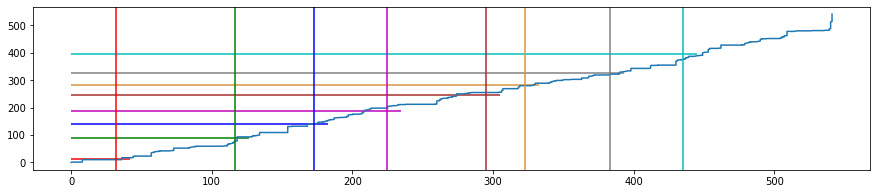

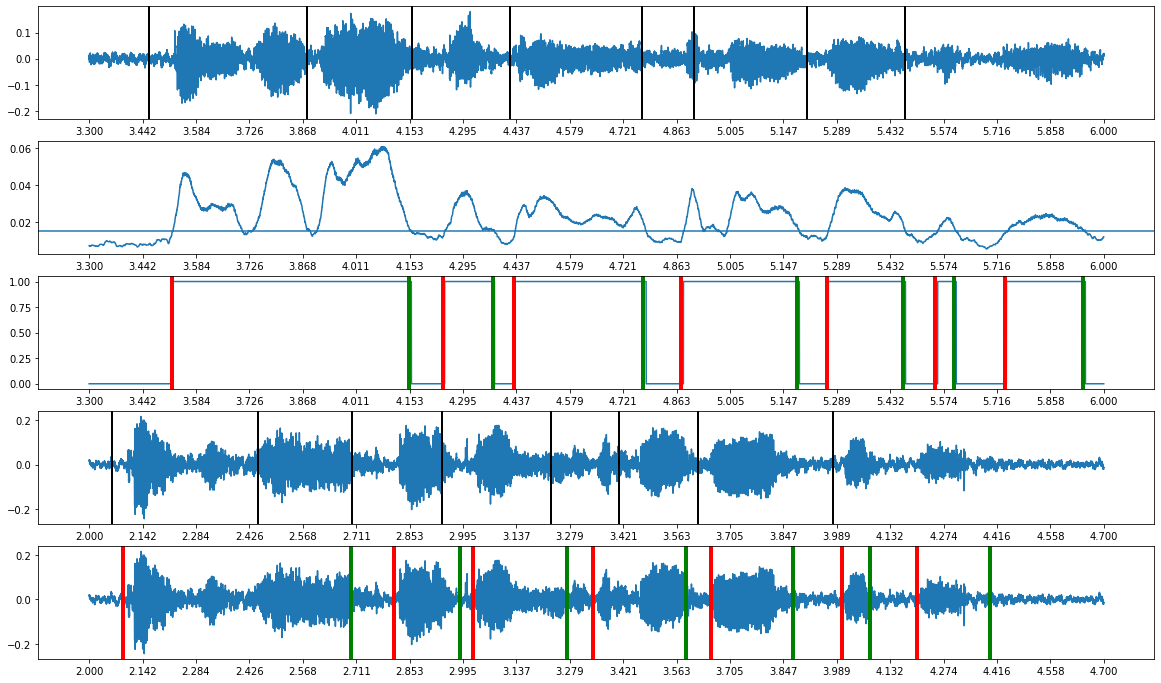

In [23]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7

timelst1 = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
timelst2 = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.015)

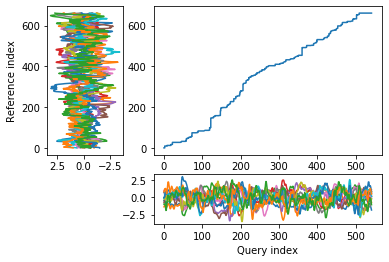

Overall normalized stretch =  0.8769701243458923
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   3.51919   4.15185   4.24151   4.37601   4.43081   4.77454   
start in voice 2   1.83948   2.76605   2.95535   3.34889   3.43856   3.74244   
stretch           0.902969  0.879473  0.858471  0.804311  0.843379  0.735613   

                        7         8         9         10        11        12  \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   4.87417   5.18303   5.26273   5.46697   5.55166   5.60148   
start in voice 2    3.8072   4.20074   4.26052    4.5345   4.61919   4.68893   
stretch           0.856509  0.787767  0.842306  0.685072  0.941385  0.916769   

                        13  
seg                 speech  
start in voice 1   5.73598  
start in voice 2   4.79852  
stretch           0.951873  

DTW

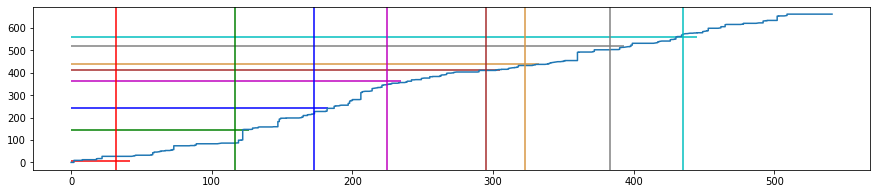

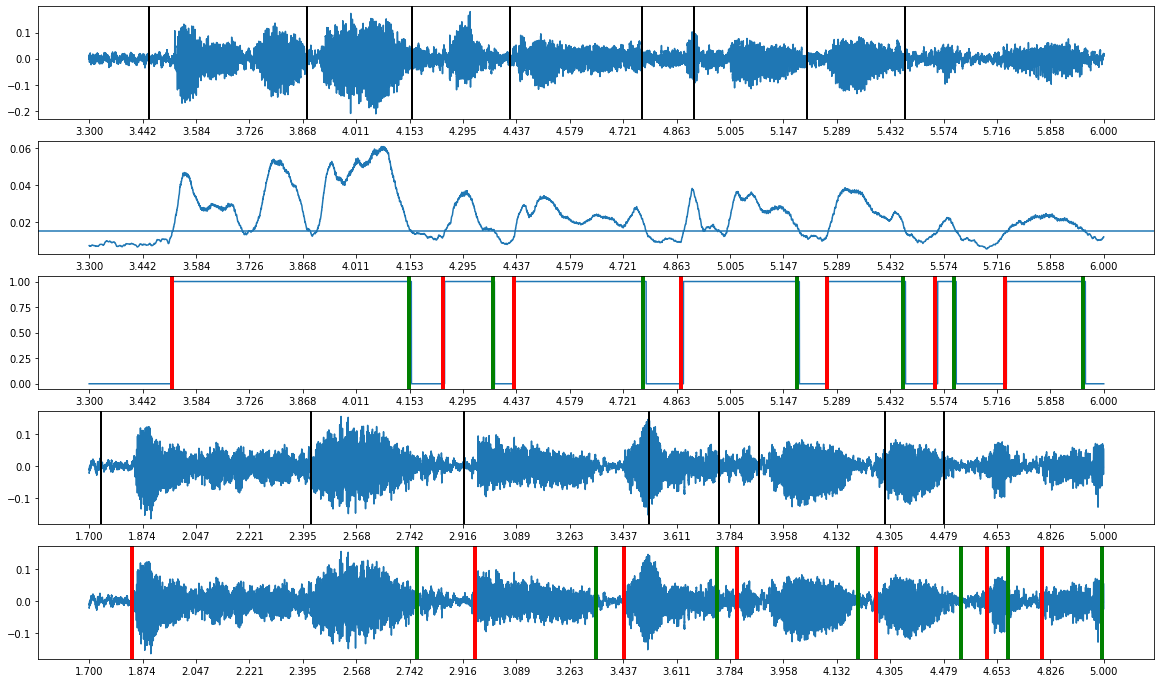

In [22]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "02.wav", 1.7, 5

timelst1 = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
timelst2 = [1.74, 2.42, 2.92, 3.52, 3.75, 3.88, 4.29, 4.48]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.015)

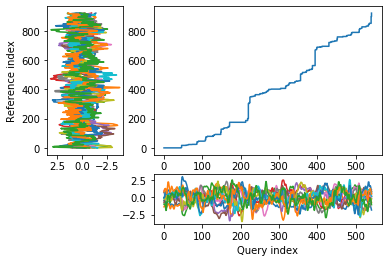

Overall normalized stretch =  0.9166086397579817
                       1        2         3         4         5         6   \
seg                speech    pause    speech     pause    speech     pause   
start in voice 1  3.51919  4.15185   4.24151   4.37601   4.43081   4.77454   
start in voice 2      1.4  2.13727   2.27177   2.33155   3.14354   3.40258   
stretch           0.88833        1  0.971459  0.974824  0.855975  0.906447   

                        7         8         9        10       11        12  \
seg                 speech     pause    speech    pause   speech     pause   
start in voice 1   4.87417   5.18303   5.26273  5.46697  5.55166   5.60148   
start in voice 2   3.42749   4.04022   4.20461  4.99668  5.11125     5.181   
stretch           0.876038  0.930724  0.978169  0.91161        1  0.897464   

                        13  
seg                 speech  
start in voice 1   5.73598  
start in voice 2   5.27066  
stretch           0.895228  

DTW distance =  2.91539

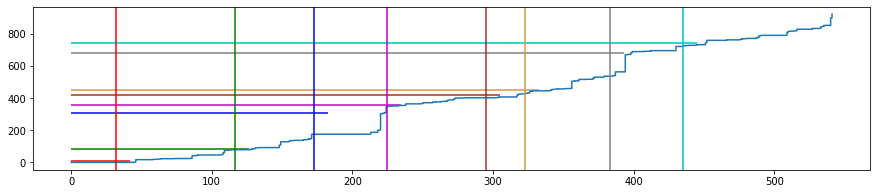

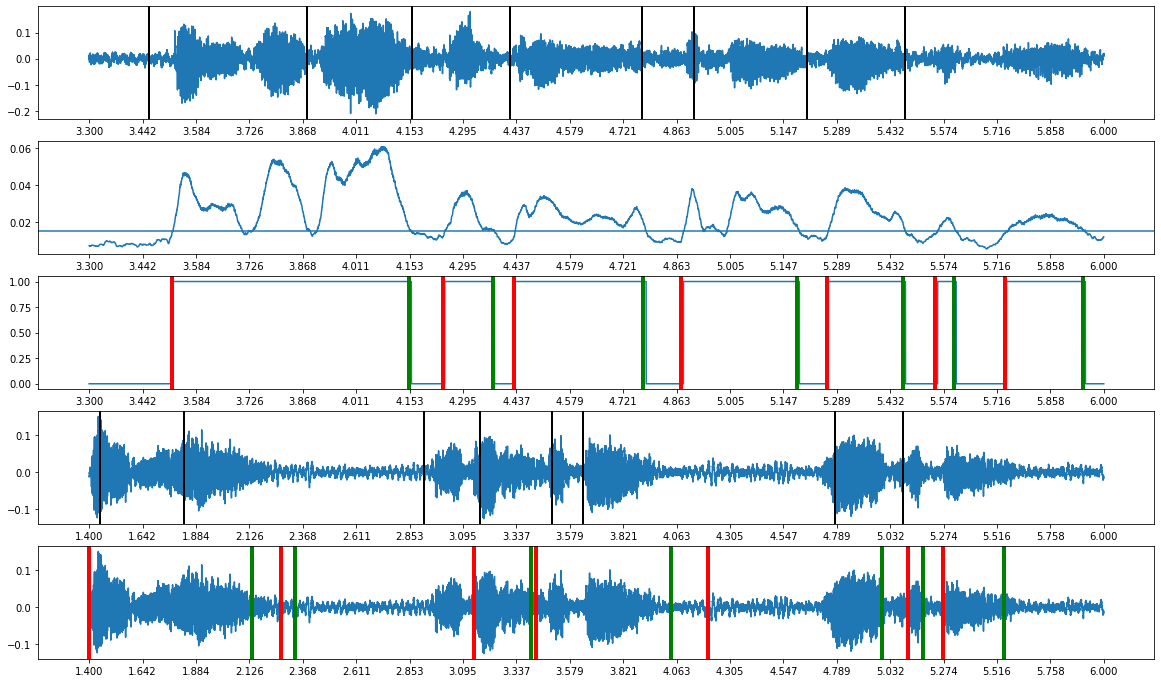

In [21]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "05.wav", 1.4, 6

timelst1 = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
timelst2 = [1.45, 1.83, 2.92, 3.17, 3.5, 3.64, 4.78, 5.09]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.015)

In [361]:
def compute_dtw(file1, file2, *args, **kwargs):
    
    num_of_mfcc = kwargs.get('num_of_mfcc', 13)
    alpha = kwargs.get('alpha', 1)

    x, sr1 = librosa.load(capstone_dir + "/py_converted/" + file1, sr=None)
    y, sr2 = librosa.load(capstone_dir + "/py_converted/" + file2, sr=None)

    fragment_x = x
    fragment_y = y

    # number of mfcc frames = audio length * samplerate / hop length (default = 512)
    # set hop_length = __ s
    hop_len_in_s = 0.05

    mfcc1 = librosa.feature.mfcc(fragment_x, sr1, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr1))
    mfcc2 = librosa.feature.mfcc(fragment_y, sr2, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr2)) 

    # normalize each mfcc
    mfcc1_normal = normalize(mfcc1)
    mfcc2_normal = normalize(mfcc2)
    
    dtw_input1 = mfcc1_normal.T
    dtw_input2 = mfcc2_normal.T
    
    alignment = dtw(dtw_input1, dtw_input2, keep_internals=True)
    alignment.plot('threeway')
    
    
    theta = math.atan(max(alignment.index2)/max(alignment.index1))  # angle of diagonal = length of y axis over length of x axis
    
    overall_stretch = 0
    overall_arclen = 0
    

    xs = alignment.index1
    ys = alignment.index2

    stretch = 0
    arclen = 0            

    for i in range(len(xs)-1):

        if i % alpha == 0:
            if xs[i+1]-xs[i] == 0:
                rho_i = math.pi/2
            else:
                rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

            dev_rho_i = deviation(rho_i, theta)
            stretch = stretch + dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
            overall_stretch = overall_stretch + stretch

        arclen = arclen + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
        overall_arclen = overall_arclen + arclen            


        
    print('Stretch = %3.2f' % (overall_stretch/overall_arclen))
    print('DTW  = %3.2f' % alignment.normalizedDistance)    
    

# 01

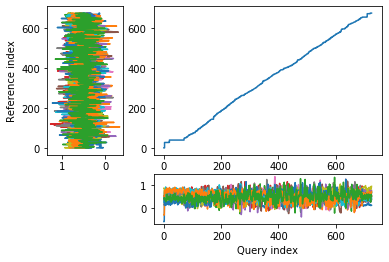

Stretch = 0.67
DTW  = 0.59


In [362]:
compute_dtw("01.wav", "01_1.wav") # normal vs normal

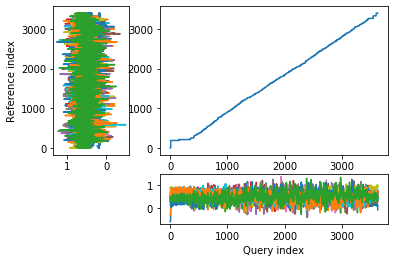

Stretch = 0.87
DTW  = 0.59


In [297]:
compute_dtw("01.wav", "01_2.wav") # normal vs normal

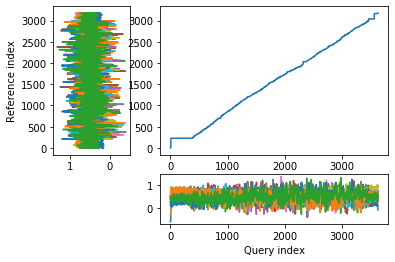

Stretch = 0.87
DTW  = 0.55


In [298]:
compute_dtw("01.wav", "01_3.wav") # normal vs normal

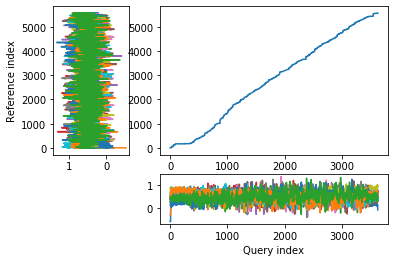

Stretch = 0.89
DTW  = 0.51


In [299]:
compute_dtw("01.wav", "02.wav") # normal vs slightly slow  

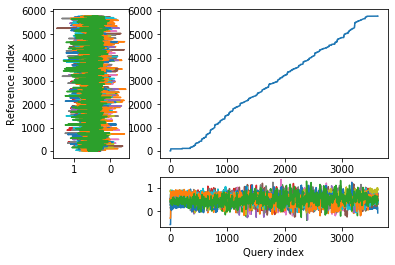

Stretch = 0.92
DTW  = 0.57


In [300]:
compute_dtw("01.wav", "05.wav") # normal vs short pauses

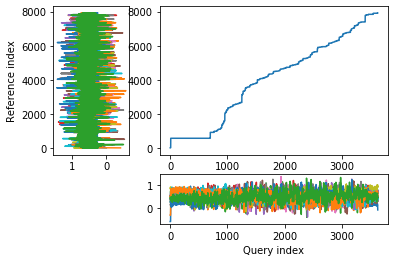

Stretch = 0.97
DTW  = 0.60


In [301]:
compute_dtw("01.wav", "pause_m01.wav") # normal vs repeat part of the word

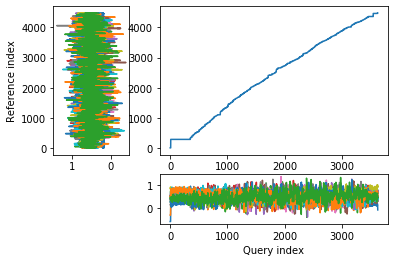

Stretch = 0.90
DTW  = 0.58


In [302]:
compute_dtw("01.wav", "02_1.wav") # normal vs slower

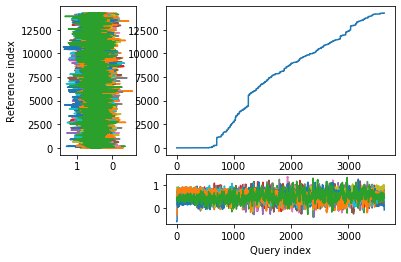

Stretch = 0.98
DTW  = 0.62


In [303]:
compute_dtw("01.wav", "long_w01.wav") # normal vs slower

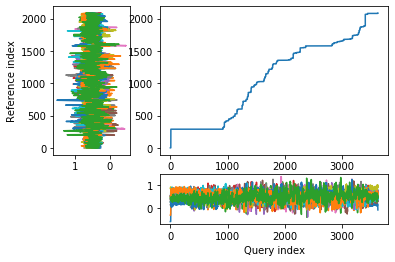

Stretch = 0.97
DTW  = 0.65


In [304]:
compute_dtw("01.wav", "repeat-syllable01.wav") # normal vs stutter

# 01_1

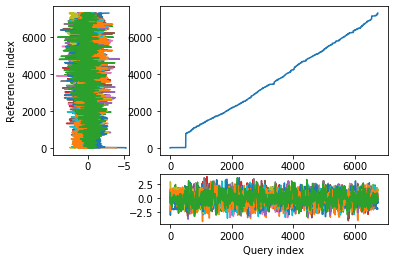

Stretch = 0.88
DTW  = 2.61


In [82]:
compute_dtw("01_1.wav", "01.wav")

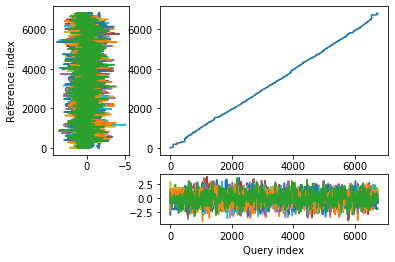

Stretch = 0.87
DTW  = 2.59


In [84]:
compute_dtw("01_1.wav", "01_2.wav") 

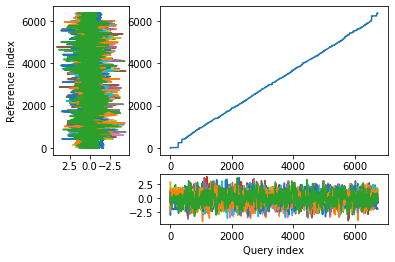

Stretch = 0.88
DTW  = 2.61


In [85]:
compute_dtw("01_1.wav", "01_3.wav")

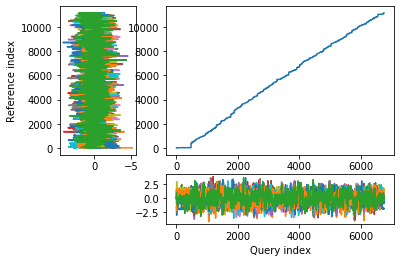

Stretch = 0.92
DTW  = 2.56


In [86]:
compute_dtw("01_1.wav", "02.wav")

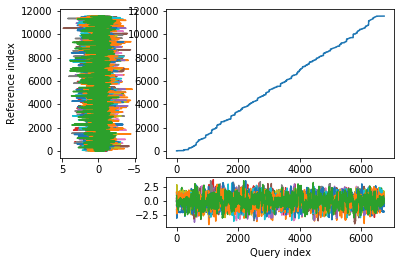

Stretch = 0.94
DTW  = 2.60


In [87]:
compute_dtw("01_1.wav", "05.wav")

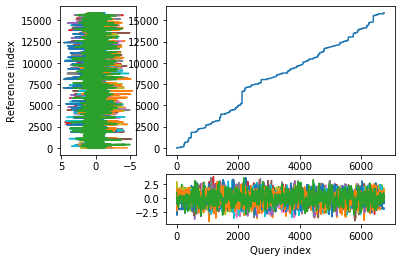

Stretch = 0.97
DTW  = 2.90


In [88]:
compute_dtw("01_1.wav", "pause_m01.wav")

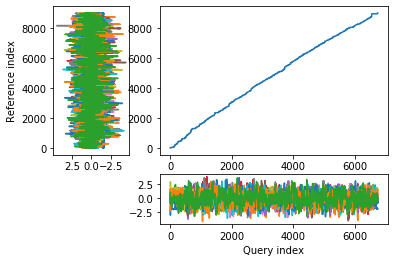

Stretch = 0.91
DTW  = 2.70


In [89]:
compute_dtw("01_1.wav", "02_1.wav")

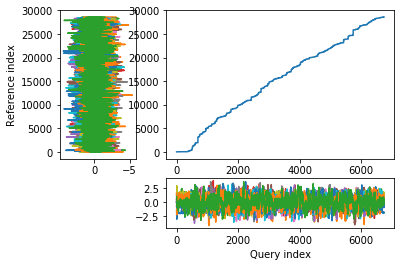

Stretch = 0.98
DTW  = 3.03


In [90]:
compute_dtw("01_1.wav", "long_w01.wav")

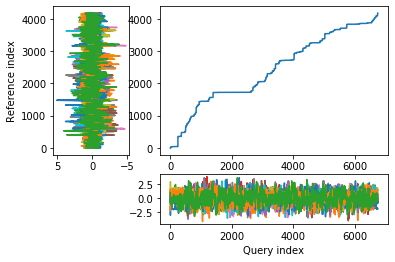

Stretch = 0.97
DTW  = 3.17


In [91]:
compute_dtw("01_1.wav", "repeat-syllable01.wav")

# 01_2

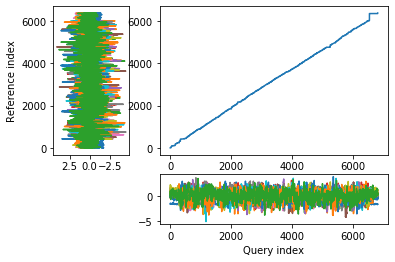

Stretch = 0.88
DTW  = 2.71


In [93]:
compute_dtw("01_2.wav", "01_3.wav")

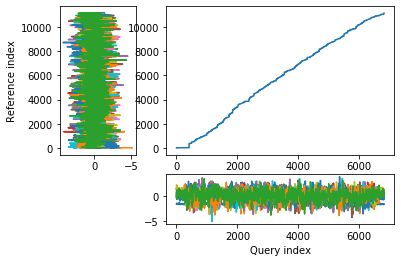

Stretch = 0.93
DTW  = 2.71


In [94]:
compute_dtw("01_2.wav", "02.wav")

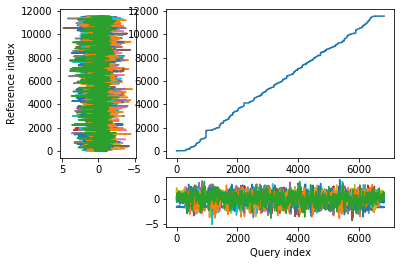

Stretch = 0.95
DTW  = 2.85


In [96]:
compute_dtw("01_2.wav", "05.wav")

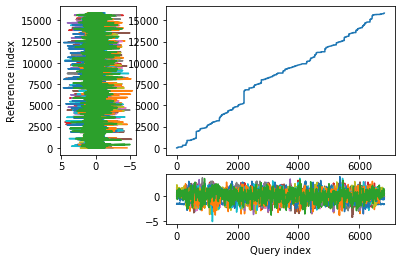

Stretch = 0.96
DTW  = 2.82


In [97]:
compute_dtw("01_2.wav", "pause_m01.wav")

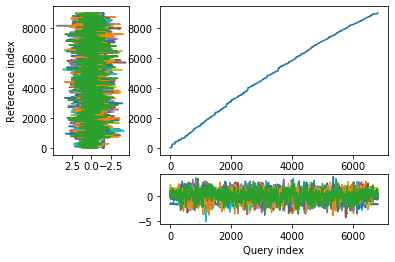

Stretch = 0.88
DTW  = 2.29


In [98]:
compute_dtw("01_2.wav", "02_1.wav")

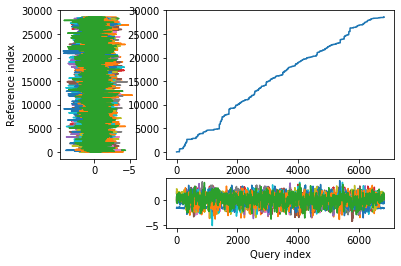

Stretch = 0.98
DTW  = 3.02


In [13]:
compute_dtw("01_2.wav", "long_w01.wav")

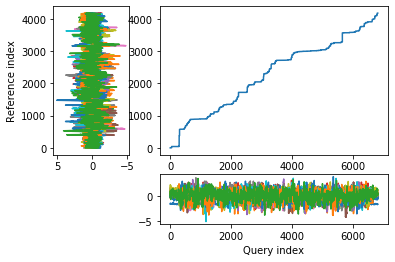

Stretch = 0.97
DTW  = 3.13


In [14]:
compute_dtw("01_2.wav", "repeat-syllable01.wav")

# 01_3

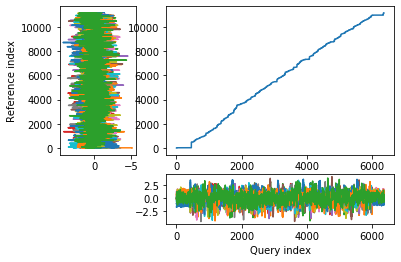

Stretch = 0.94
DTW  = 2.72


In [17]:
compute_dtw("01_3.wav", "02.wav")

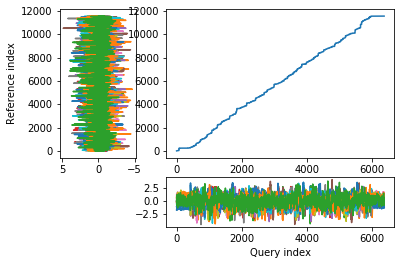

Stretch = 0.94
DTW  = 2.79


In [18]:
compute_dtw("01_3.wav", "05.wav")

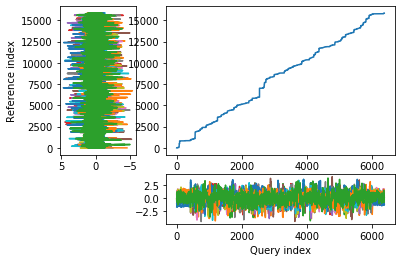

Stretch = 0.96
DTW  = 2.77


In [19]:
compute_dtw("01_3.wav", "pause_m01.wav")

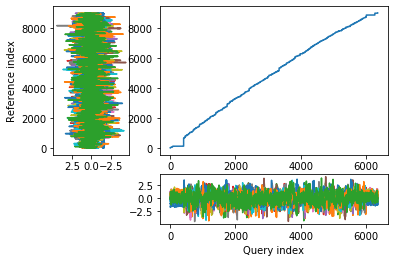

Stretch = 0.93
DTW  = 2.82


In [20]:
compute_dtw("01_3.wav", "02_1.wav")

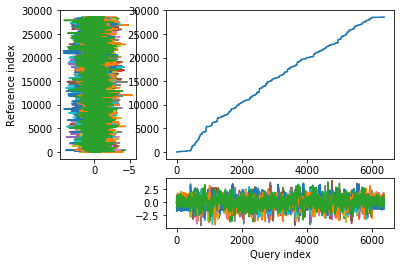

Stretch = 0.98
DTW  = 2.94


In [21]:
compute_dtw("01_3.wav", "long_w01.wav")

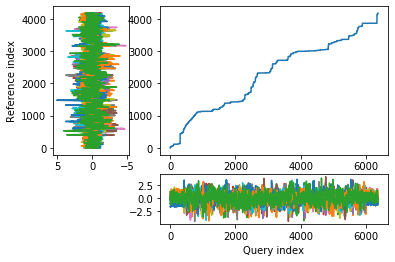

Stretch = 0.96
DTW  = 3.07


In [16]:
compute_dtw("01_3.wav", "repeat-syllable01.wav")

# 02

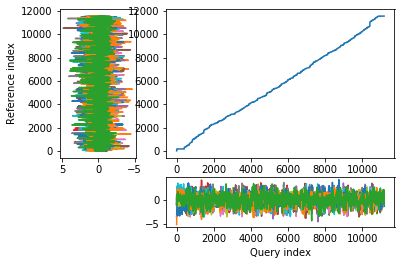

Stretch = 0.90
DTW  = 2.35


In [22]:
compute_dtw("02.wav", "05.wav")

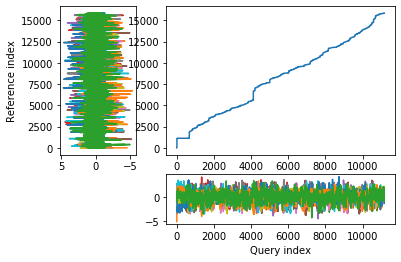

Stretch = 0.94
DTW  = 2.55


In [23]:
compute_dtw("02.wav", "pause_m01.wav")

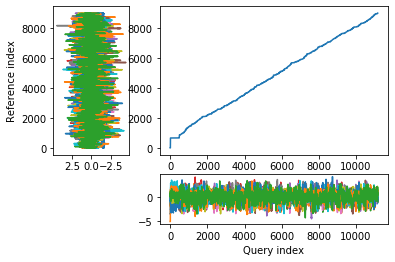

Stretch = 0.92
DTW  = 2.64


In [24]:
compute_dtw("02.wav", "02_1.wav")

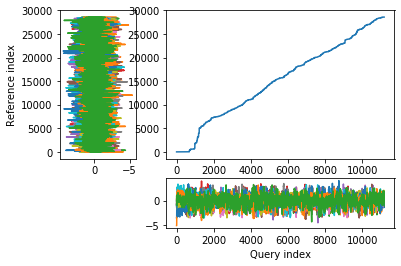

Stretch = 0.96
DTW  = 2.58


In [25]:
compute_dtw("02.wav", "long_w01.wav")

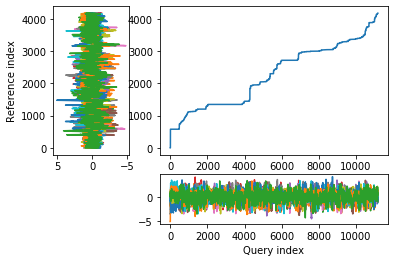

Stretch = 0.98
DTW  = 3.10


In [26]:
compute_dtw("02.wav", "repeat-syllable01.wav")

# 05

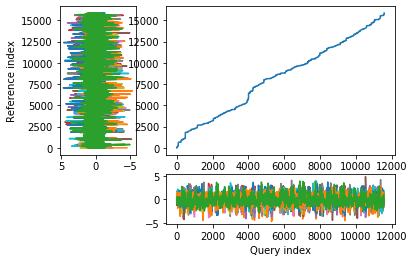

Stretch = 0.94
DTW  = 2.52


In [27]:
compute_dtw("05.wav", "pause_m01.wav")

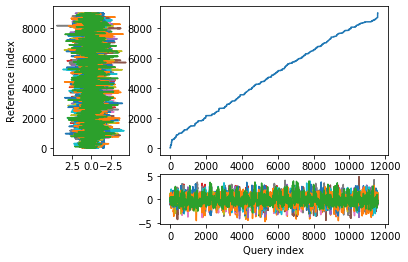

Stretch = 0.94
DTW  = 2.78


In [28]:
compute_dtw("05.wav", "02_1.wav")

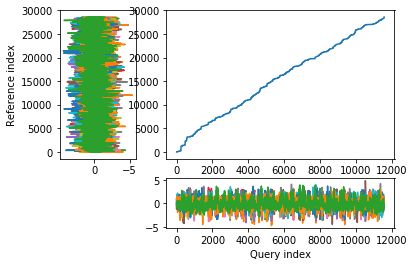

Stretch = 0.97
DTW  = 2.76


In [29]:
compute_dtw("05.wav", "long_w01.wav")

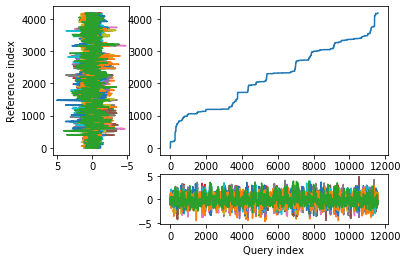

Stretch = 0.98
DTW  = 3.06


In [30]:
compute_dtw("05.wav", "repeat-syllable01.wav")

# pause_m01

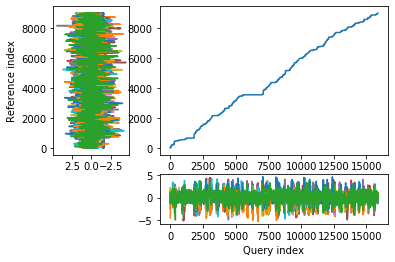

Stretch = 0.95
DTW  = 2.79


In [31]:
compute_dtw("pause_m01.wav", "02_1.wav")

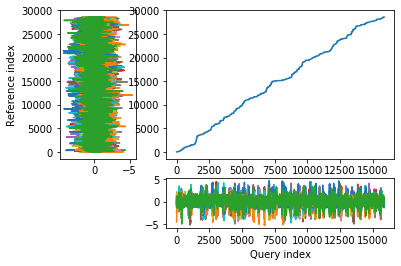

Stretch = 0.95
DTW  = 2.47


In [32]:
compute_dtw("pause_m01.wav", "long_w01.wav")

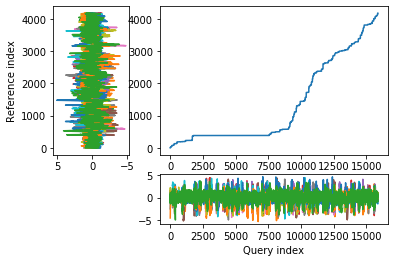

Stretch = 0.99
DTW  = 2.98


In [33]:
compute_dtw("pause_m01.wav", "repeat-syllable01.wav")

# 02_1

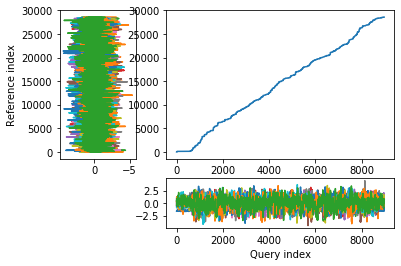

Stretch = 0.97
DTW  = 2.89


In [34]:
compute_dtw("02_1.wav", "long_w01.wav")

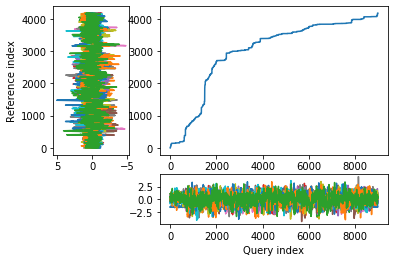

Stretch = 0.96
DTW  = 3.13


In [35]:
compute_dtw("02_1.wav", "repeat-syllable01.wav")

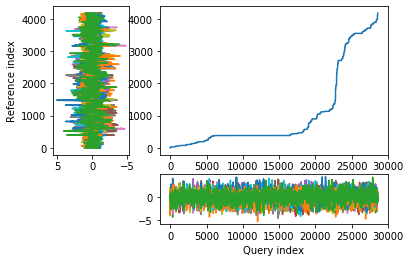

Stretch = 0.99
DTW  = 3.23


In [36]:
compute_dtw("long_w01.wav", "repeat-syllable01.wav")

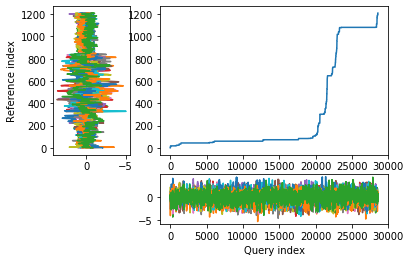

Stretch = 1.00
DTW  = 3.32


In [37]:
compute_dtw("long_w01.wav", "report-normal1.wav")

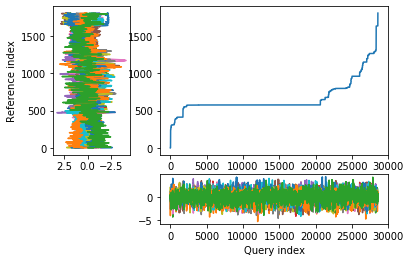

Stretch = 1.00
DTW  = 3.59


In [39]:
compute_dtw("long_w01.wav", "torgo-healthy.wav")

# We have really enjoyed the project - by syllable

### normal vs normal

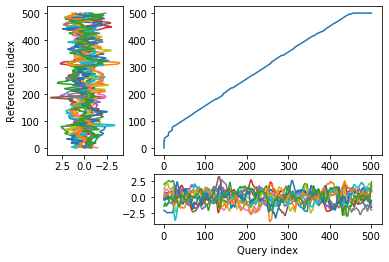

Stretch = 0.06

Distance  = 361.59
                         1        2          3          4         5        6   \
seg                  speech    pause     speech      pause    speech    pause   
start in voice 1    1.62948   1.7241    1.79382    1.95817   2.14243  2.37151   
start in voice 2    1.91335  2.00299    2.07271    2.24203   2.41135  2.65538   
stretch           0.0399335        0  0.0216194  0.0603998  0.131585        0   

                         7        8        9         10         11        12  \
seg                  speech    pause   speech     pause     speech     pause   
start in voice 1    2.40637  2.61056  2.66036   2.73506    2.80976   3.08367   
start in voice 2    2.69024  2.88944  2.93924   3.01394    3.10359   3.37251   
stretch           0.0178081        0        0  0.131585  0.0900777  0.020978   

                        13        14         15       16        17  
seg                 speech     pause     speech    pause    speech  
start in voice 1   3

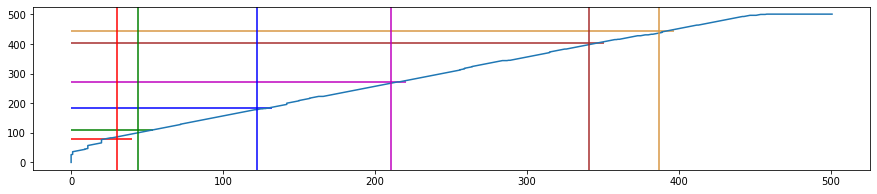

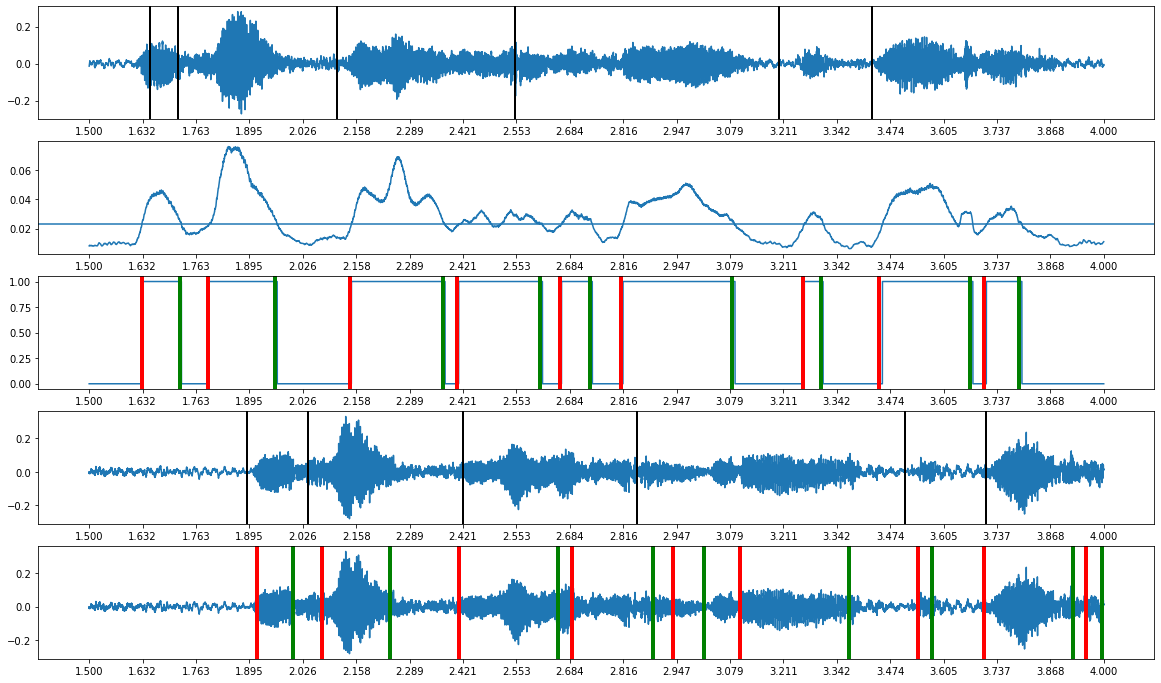

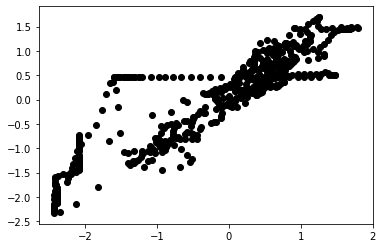

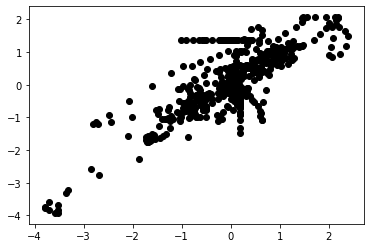

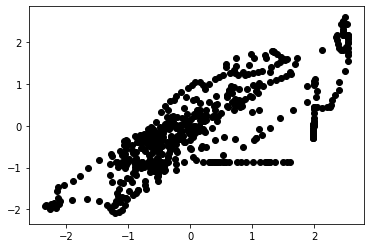

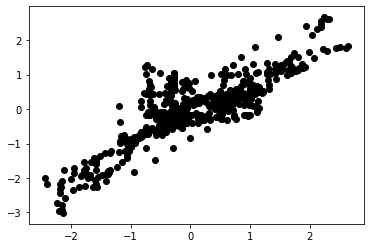

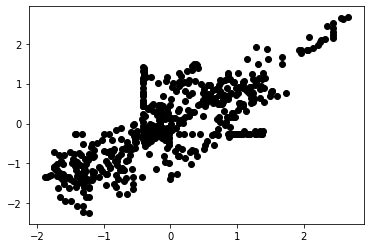

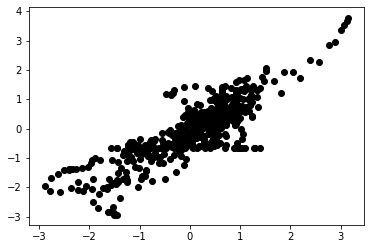

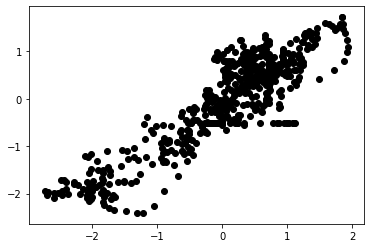

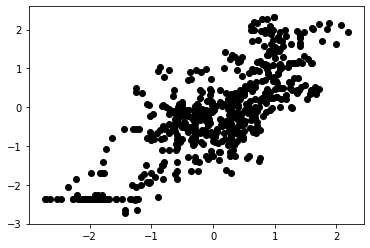

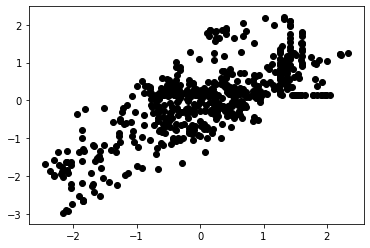

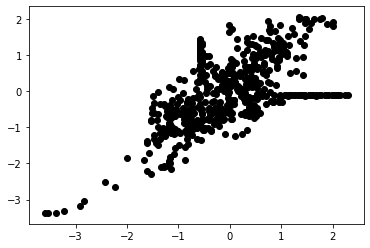

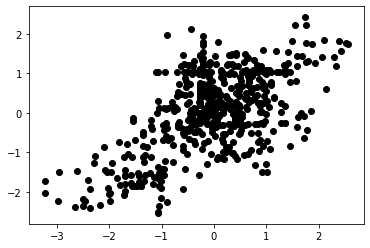

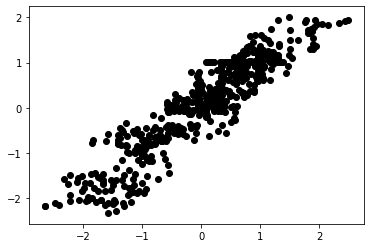

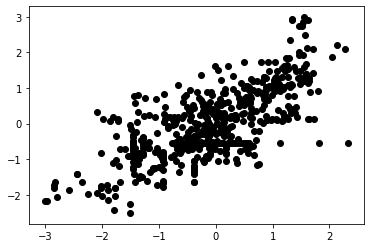

In [247]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal2.wav", 1.5, 4

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1=0.023, 
      timelst1=timelst1, timelst2 = timelst2)
# unit for input_min_pause and alpha = ms 

### normal vs pause

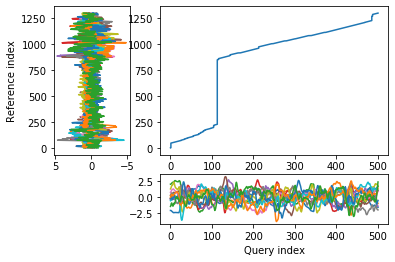

Stretch = 0.92

Distance  = 964.81
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   1.62948    1.7241   1.79382   1.95817   2.14243   2.37151   
start in voice 2   2.35857   2.49801   2.59761   2.90637   6.35757   6.60159   
stretch           0.517853  0.507966  0.602263  0.952999  0.486926  0.347388   

                        7         8         9         10        11        12  \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   2.40637   2.61056   2.66036   2.73506   2.80976   3.08367   
start in voice 2   6.63645   6.91036   6.96016   7.01494   7.08964   7.32869   
stretch           0.476859  0.347388  0.491276  0.347388  0.409568  0.448492   

                        13       14        15        16        17  
seg                 speech    pause    speech     pause    speech  
start in voice 1   3.25797 

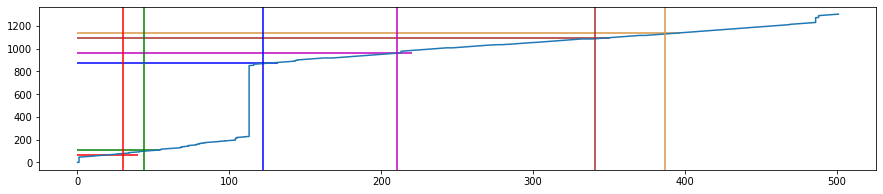

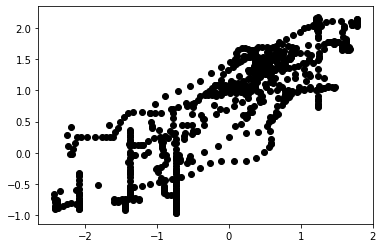

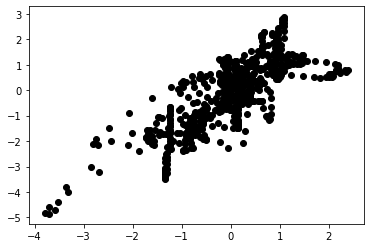

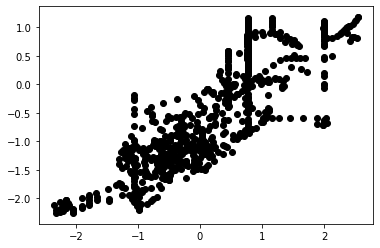

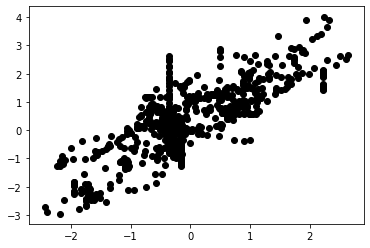

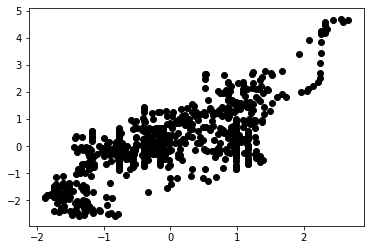

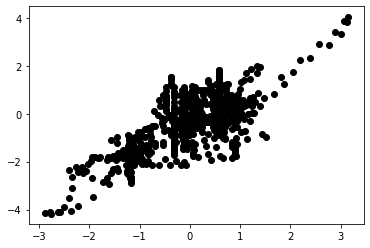

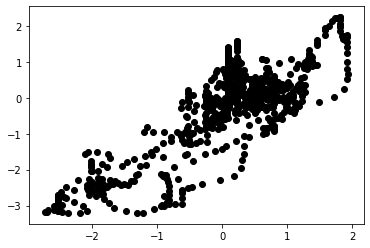

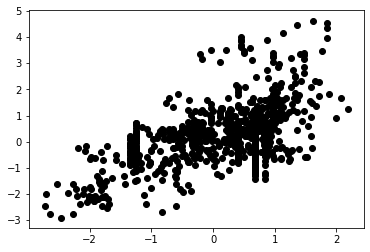

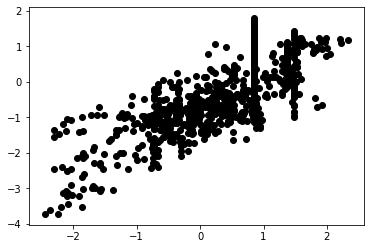

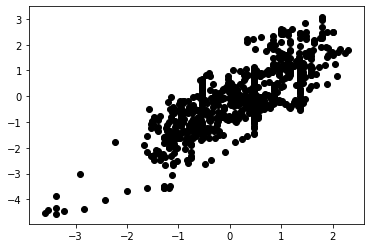

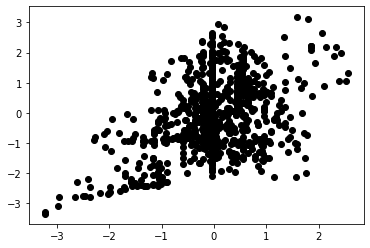

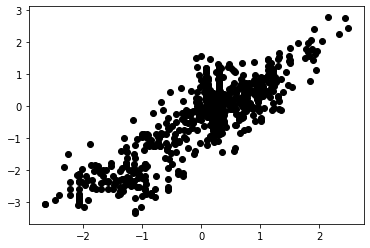

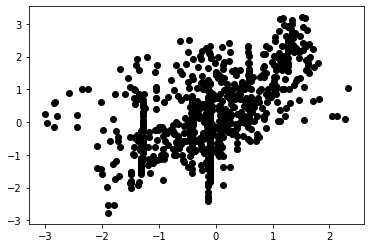

In [242]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.023,
      timelst1=timelst1, timelst2 = timelst2)